In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
np.random.seed(45)
num_samples = 40

# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps


In [6]:
#PART A
X1_tensor  = torch.from_numpy(x1).reshape(-1,1 )
y_tensor = torch.from_numpy(y).reshape(-1, 1)
theta_0 = torch.tensor([1.0], requires_grad=True)  # θ0 is the bias term
theta_1 = torch.tensor([1.0], requires_grad=True)  # θ1 is the weight term

# Define the linear model: θ1 * x + θ0
y_pred = theta_1 * X1_tensor + theta_0

# Define the loss function (Mean Squared Error)
loss = torch.mean((y_pred - y_tensor) ** 2)

# Compute gradients using autograd
loss.backward()

# Output the true gradients
print(f"True gradient w.r.t θ0: {theta_0.grad.item()}")
print(f"True gradient w.r.t θ1: {theta_1.grad.item()}")
c_theta_0=theta_0.grad.item()
c_theta_1=theta_1.grad.item()


True gradient w.r.t θ0: -5.616434574127197
True gradient w.r.t θ1: -0.5629974603652954


In [7]:
##PART B
# Reset gradients before calculating stochastic gradients
theta_0.grad.data.zero_()
theta_1.grad.data.zero_()

# Storing individual gradients for each point
stochastic_grad_θ0 = []
stochastic_grad_θ1 = []

# Loop through each data point to calculate gradients
for i in range(num_samples):
    # Get individual data point
    x_i = X1_tensor[i]
    y_i = y_tensor[i]

    # Recompute prediction for individual point
    y_pred_i = theta_1 * x_i + theta_0

    # Compute loss for individual point
    loss_i = (y_pred_i - y_i) ** 2

    # Backpropagate to compute gradients for this point
    loss_i.backward(retain_graph=True)

    # Store gradients for this point
    stochastic_grad_θ0.append(theta_0.grad.item())
    stochastic_grad_θ1.append(theta_1.grad.item())

    # Reset gradients for the next iteration
    theta_0.grad.data.zero_()
    theta_1.grad.data.zero_()

## Given true gradients from Part A
true_grad_theta_0 = c_theta_0
true_grad_theta_1 = c_theta_1
avg_stochastic_grad_θ0 = np.mean(stochastic_grad_θ0)
avg_stochastic_grad_θ1 = np.mean(stochastic_grad_θ1)

# Output the average stochastic gradients
print(f"Average stochastic gradient w.r.t θ0: {avg_stochastic_grad_θ0}")
print(f"Average stochastic gradient w.r.t θ1: {avg_stochastic_grad_θ1}")

# Compare with true gradients
diff_θ0 = abs(true_grad_theta_0 - avg_stochastic_grad_θ0)
diff_θ1 = abs(true_grad_theta_1 - avg_stochastic_grad_θ1)

print(f"Difference for θ0: {diff_θ0}")
print(f"Difference for θ1: {diff_θ1}")


Average stochastic gradient w.r.t θ0: -5.616434797644615
Average stochastic gradient w.r.t θ1: -0.5629974387586116
Difference for θ0: 2.2351741790771484e-07
Difference for θ1: 2.1606683775488023e-08


In [8]:
def create_XYZ(f, x_data, y_data, x_true, y_true):
    divisions = 100
    # Generate data
    x = np.linspace(x_true-10, x_true+10, divisions)
    y = np.linspace(y_true-10, y_true+10, divisions)
    X, Y = np.meshgrid(x, y)

    # Convert to PyTorch tensors
    X_torch = torch.from_numpy(X)
    Y_torch = torch.from_numpy(Y)

    Z=torch.zeros((divisions, divisions))
    # Evaluate the function
    for i in range(divisions):
        for j in range(divisions):
            Z[i][j] = f(X_torch[i][j], Y_torch[i][j], x_data, y_data)
    return X,Y,Z,X_torch,Y_torch

def create_contour(X, Y, Z, ax2, alpha, scatter_pts=None, filled=True, levels=10, mark_levels=False):
    if filled:
        scatter_color='white'
        contour = ax2.contourf(X, Y, Z.detach().numpy(), levels=levels, cmap='magma', alpha=alpha)
    else:
        scatter_color='black'
        contour = ax2.contour(X, Y, Z.detach().numpy(), levels=levels, cmap='magma', alpha=alpha)
    if scatter_pts is not None:
        ax2.scatter(scatter_pts[0], scatter_pts[1], s=10, c=scatter_color)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Contour Plot')

    # Add a colorbar in between the subplots
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(contour, cax=cax)
    return ax2, contour



In [9]:
def loss_func(theta0, theta1, X, y):
    return ((y-(theta0+(X*theta1)))**2).sum()/len(y)

In [10]:
theta0=torch.tensor(6.0)
theta1=torch.tensor(10.0)
a=0.1
epoch=15
epsilon=0.001
momentum=0.3

In [11]:
#FULL BATCH
def FBG(X, y, theta0, theta1, theta0_true, theta1_true,a, epoch, loss_fx):
    plt.rcParams['figure.figsize'] = [15, 5]
    theta0_data, theta1_data, Z, theta0_data_torch, theta1_data_torch = create_XYZ(loss_fx, X, y,theta0_true, theta1_true)

    levels = [0, 10, 25, 50, 100, 200, 300, 400]
    loss = [loss_fx(theta0, theta1, X, y)]
    epoch_lst=[0]
    theta0_i = theta0
    theta1_i = theta1

    fig, ax = plt.subplots(ncols=2)
    _,_ = create_contour(theta0_data, theta1_data, Z, ax[0], alpha=0.8, scatter_pts=(theta0_i, theta1_i), filled=True, levels=levels)
    # Mark the minima with horizontal and vertical lines
    ax[0].axhline(y=theta1_i, color='red', linestyle='--', alpha=0.7)
    ax[0].axvline(x=theta0_i, color='red', linestyle='--', alpha=0.7)
    ax[0].scatter([theta0_true], [theta1_true], s=10, c='pink', marker='x', label='Minima')
    # plot the line fit
    x_line = np.linspace(X.min(), X.max(), 100)
    y_line = theta0_i + theta1_i*x_line
    y_true = theta1_true*x_line + theta0_true
    ax[1].plot(x_line, y_line, label='Line fit')
    ax[1].plot(x_line, y_true, label='Actual line')
    ax[1].plot(X, y, 'o')
    ax[1].legend()
    plt.title(f'Epoch:{0}\nTheta = {(theta0_i, theta1_i)}', y=1.1)

    for i in range(200):
        #Performing gradient descent
        theta0_prev, theta1_prev = theta0_i, theta1_i
        del_theta0, del_theta1 = torch.func.grad(loss_fx, argnums=(0, 1))(theta0_i, theta1_i, X, y)
        theta0_i = theta0_i - a * del_theta0
        theta1_i = theta1_i - a * del_theta1
        #Plot for first 15 epochs
        if i<epoch:
            fig, ax = plt.subplots(ncols=2)
            _,_= create_contour(theta0_data, theta1_data, Z, ax[0], alpha=0.8, scatter_pts=(theta0_i, theta1_i), filled=True, levels=levels)
            # Mark the minima with horizontal and vertical lines
            ax[0].axhline(y=theta1_i, color='red', linestyle='--', alpha=0.7)
            ax[0].axvline(x=theta0_i, color='red', linestyle='--', alpha=0.7)
            ax[0].scatter([theta0_true], [theta1_true], s=10, c='pink', marker='x', label='Minima')
            x_line = np.linspace(X.min(), X.max(), 100)
            y_line = theta0_i + theta1_i*x_line
            y_true = theta1_true*x_line + theta0_true
            ax[1].plot(x_line, y_line, label='Line fit')
            ax[1].plot(x_line, y_true, label='Actual line')
            ax[1].plot(X, y, 'o')
            ax[1].legend()
            plt.title(f'Epoch:{i+1}\nTheta = {(theta0_i, theta1_i)}', y=1.1)

        loss.append(loss_fx(theta0_i, theta1_i, X, y))
        epoch_lst.append(i+1)
        if abs(theta0_prev - theta0_i)<0.001 and abs(theta1_prev-theta1_i)<0.001:
            break
    plt.figure(figsize=(15, 10))
    plt.plot(epoch_lst, loss, '-o')
    plt.title('Full Batch Gradient Descent')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    return epoch_lst, loss

In [12]:
def MBGD(X, y, theta0, theta1, theta0_true, theta1_true, a, epoch, batch_size, loss_fx):
    plt.rcParams['figure.figsize'] = [15, 5]
    theta0_data, theta1_data, Z, theta0_data_torch, theta1_data_torch = create_XYZ(loss_fx, X, y,theta0_true, theta1_true)

    levels = [0, 10, 25, 50, 100, 200, 300, 400]
    loss = [loss_fx(theta0, theta1, X, y)]
    epoch_lst = [0]
    theta0_i = theta0
    theta1_i = theta1

    fig, ax = plt.subplots(ncols=2)
    _, _ = create_contour(theta0_data, theta1_data, Z, ax[0], alpha=0.8, scatter_pts=(theta0_i, theta1_i), filled=True, levels=levels)
    ax[0].axhline(y=theta1_i, color='red', linestyle='--', alpha=0.7)
    ax[0].axvline(x=theta0_i, color='red', linestyle='--', alpha=0.7)
    ax[0].scatter([theta0_true], [theta1_true], s=10, c='pink', marker='x', label='Minima')

    x_line = np.linspace(X.min(), X.max(), 100)
    y_line = theta0_i + theta1_i*x_line
    y_true = theta1_true*x_line + theta0_true
    ax[1].plot(x_line, y_line, label='Line fit')
    ax[1].plot(x_line, y_true, label='Actual line')
    ax[1].plot(X, y, 'o')
    ax[1].legend()
    plt.title(f'Epoch:{0}\nTheta = {(theta0_i, theta1_i)}', y=1.1)

    n_samples = X.shape[0]

    for i in range(epoch):
        # Shuffle the dataset
        idx = torch.randperm(n_samples)
        X_shuffled = X[idx]
        y_shuffled = y[idx]

        # Iterate over mini-batches
        for start_idx in range(0, n_samples, batch_size):
            end_idx = min(start_idx + batch_size, n_samples)
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]

            # Performing gradient descent on mini-batch
            theta0_prev, theta1_prev = theta0_i, theta1_i
            del_theta0, del_theta1 = torch.func.grad(loss_fx, argnums=(0, 1))(theta0_i, theta1_i, X_batch, y_batch)
            theta0_i = theta0_i - a * del_theta0
            theta1_i = theta1_i - a * del_theta1

        # Plot for first few epochs
        if i < 15:
            fig, ax = plt.subplots(ncols=2)
            _, _ = create_contour(theta0_data, theta1_data, Z, ax[0], alpha=0.8, scatter_pts=(theta0_i, theta1_i), filled=True, levels=levels)
            ax[0].axhline(y=theta1_i, color='red', linestyle='--', alpha=0.7)
            ax[0].axvline(x=theta0_i, color='red', linestyle='--', alpha=0.7)
            ax[0].scatter([theta0_true], [theta1_true], s=10, c='pink', marker='x', label='Minima')
            y_line = theta0_i + theta1_i*x_line
            ax[1].plot(x_line, y_line, label='Line fit')
            ax[1].plot(x_line, y_true, label='Actual line')
            ax[1].plot(X, y, 'o')
            ax[1].legend()
            plt.title(f'Epoch:{i+1}\nTheta = {(theta0_i, theta1_i)}', y=1.1)

        loss.append(loss_fx(theta0_i, theta1_i, X, y))
        epoch_lst.append(i+1)

        # Stop if the changes in theta are small
        if abs(theta0_prev - theta0_i) < 0.001 and abs(theta1_prev - theta1_i) < 0.001:
            break

    # Plot loss curve
    plt.figure(figsize=(15, 10))
    plt.plot(epoch_lst, loss, '-o')
    plt.title('Mini-Batch Gradient Descent')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    return epoch_lst, loss


In [13]:
#STOCHASTIC GRADIENT DESCENT
def SGD(X, y, theta0, theta1, theta0_true, theta1_true,a, epoch, loss_fx):
    plt.rcParams['figure.figsize'] = [15, 5]
    # with_latex(columns=2, fig_width=6.5, fig_height=3)
    theta0_data, theta1_data, Z, theta0_data_torch, theta1_data_torch = create_XYZ(loss_fx, X, y,theta0_true, theta1_true)
    levels = [0, 10, 25, 50, 100, 200, 300, 400]
    loss = [loss_fx(theta0, theta1, X, y)]
    epoch_lst=[0]
    theta0_i = theta0
    theta1_i = theta1
    fig, ax = plt.subplots(ncols=2)
    _,_ = create_contour(theta0_data, theta1_data, Z, ax[0], alpha=0.8, scatter_pts=(theta0_i, theta1_i), filled=True, levels=levels)
    # Mark the minima with horizontal and vertical lines
    ax[0].axhline(y=theta1_i, color='red', linestyle='--', alpha=0.7)
    ax[0].axvline(x=theta0_i, color='red', linestyle='--', alpha=0.7)
    ax[0].scatter([theta0_true], [theta1_true], s=10, c='pink', marker='x', label='Minima')
    # plot the line fit
    x_line = np.linspace(X.min(), X.max(), 100)
    y_line = theta0_i + theta1_i*x_line
    y_true = theta1_true*x_line + theta0_true
    ax[1].plot(x_line, y_line, label='Line fit')
    ax[1].plot(x_line, y_true, label='Actual line')
    ax[1].plot(X, y, 'o')
    ax[1].legend()
    plt.title(f'Epoch:{0}\nTheta = {(theta0_i, theta1_i)}', y=1.1)

    for i in range(200):
        theta0_prev, theta1_prev = theta0_i, theta1_i
        for j in range(len(X)):
            del_theta0, del_theta1 = torch.func.grad(loss_fx, argnums=(0, 1))(theta0_i, theta1_i, X[j], y[j])
            theta0_i = theta0_i - a * del_theta0
            theta1_i = theta1_i - a * del_theta1
        if i<epoch:
            fig, ax = plt.subplots(ncols=2)
            _,_ = create_contour(theta0_data, theta1_data, Z, ax[0], alpha=0.8, scatter_pts=(theta0_i, theta1_i), filled=True, levels=levels)
            # Mark the minima with horizontal and vertical lines
            ax[0].axhline(y=theta1_i, color='red', linestyle='--', alpha=0.7)
            ax[0].axvline(x=theta0_i, color='red', linestyle='--', alpha=0.7)
            ax[0].scatter([theta0_true], [theta1_true], s=10, c='pink', marker='x', label='Minima')
            # plot the line fit
            x_line = np.linspace(X.min(), X.max(), 100)
            y_line = theta0_i + theta1_i*x_line
            y_true = theta1_true*x_line + theta0_true
            ax[1].plot(x_line, y_line, label='Line fit')
            ax[1].plot(x_line, y_true, label='Actual line')
            ax[1].plot(X, y, 'o')
            ax[1].legend()
            plt.title(f'Epoch:{i+1}\nTheta = {(theta0_i, theta1_i)}', y=1.1)
        loss.append(loss_fx(theta0_i, theta1_i, X, y))
        epoch_lst.append(i+1)
        if abs(theta0_prev - theta0_i)<0.001 and abs(theta1_prev-theta1_i)<0.001:
            break
    plt.figure(figsize=(15, 10))
    plt.plot(epoch_lst, loss, '-o')
    plt.title('Stochastic Gradient Descent')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    return epoch_lst, loss

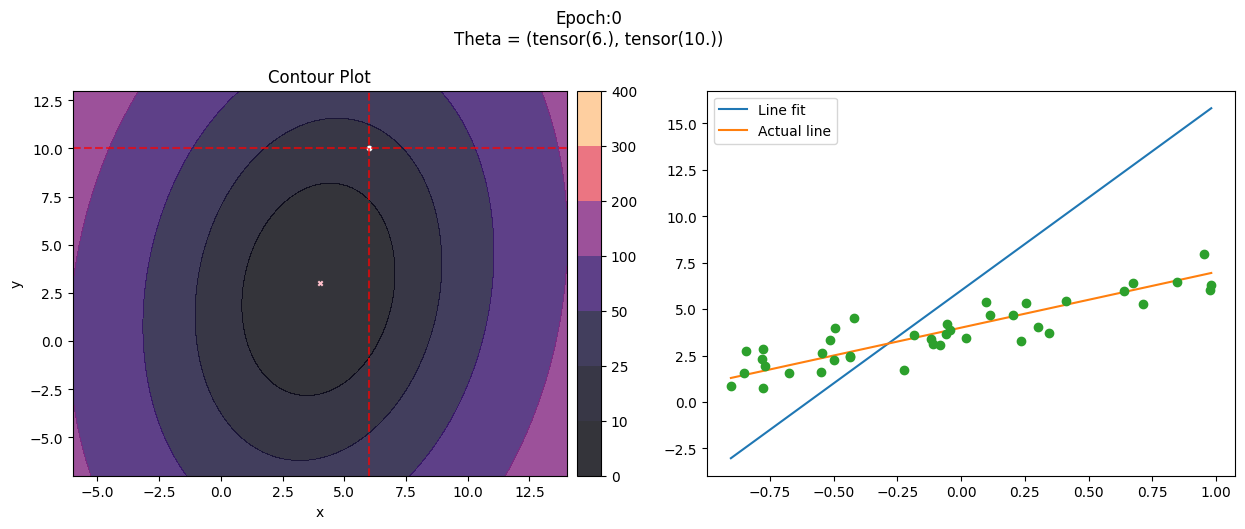

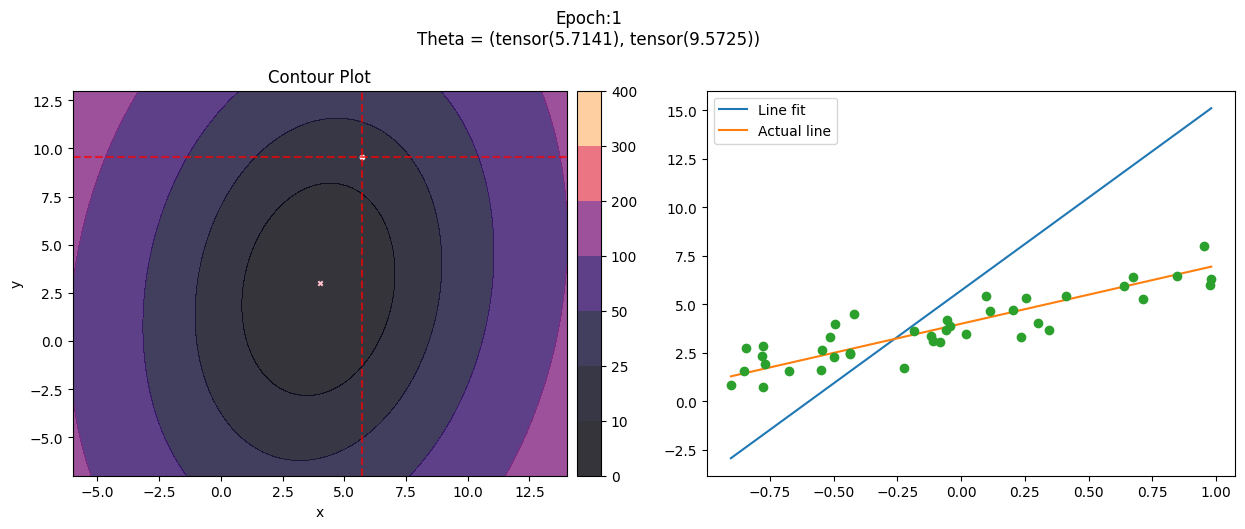

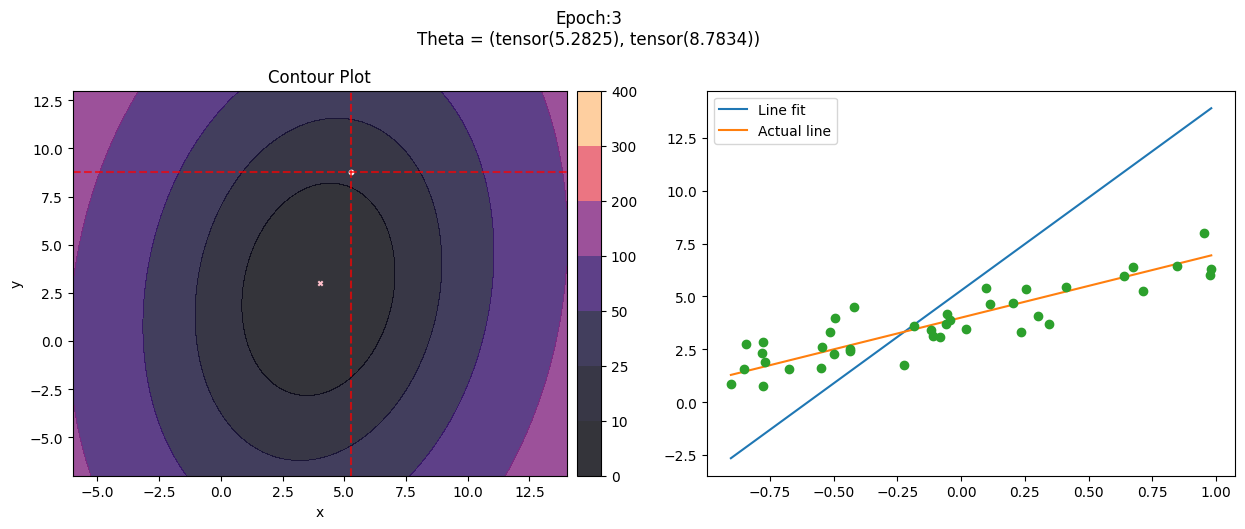

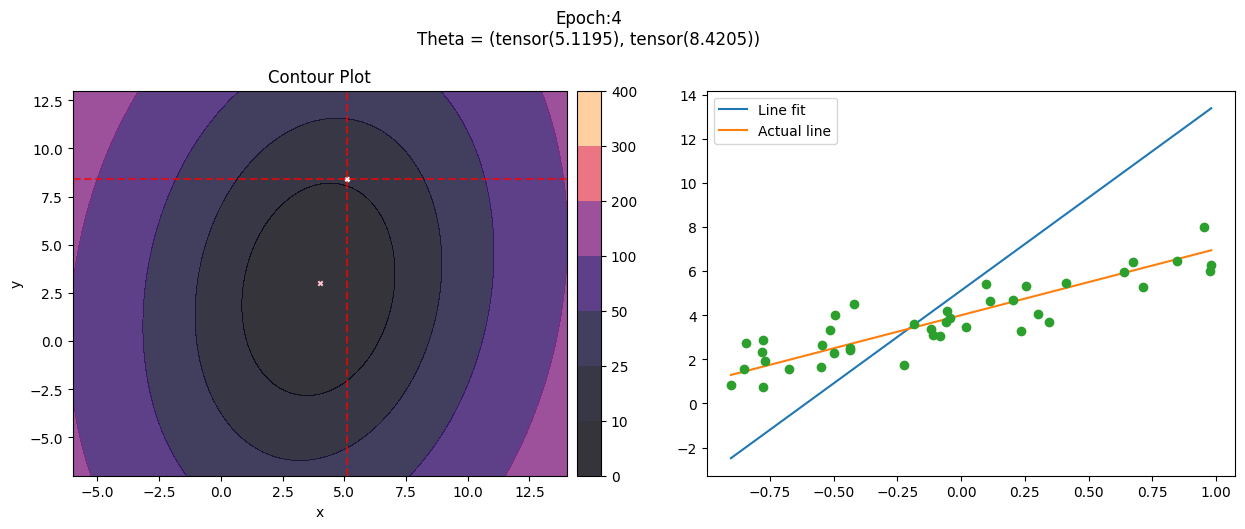

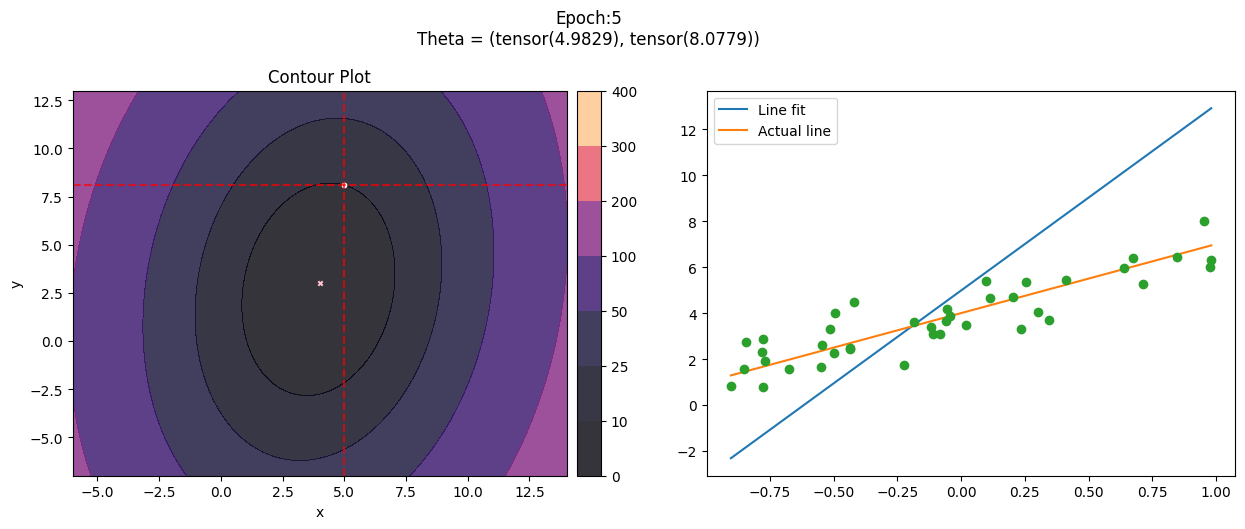

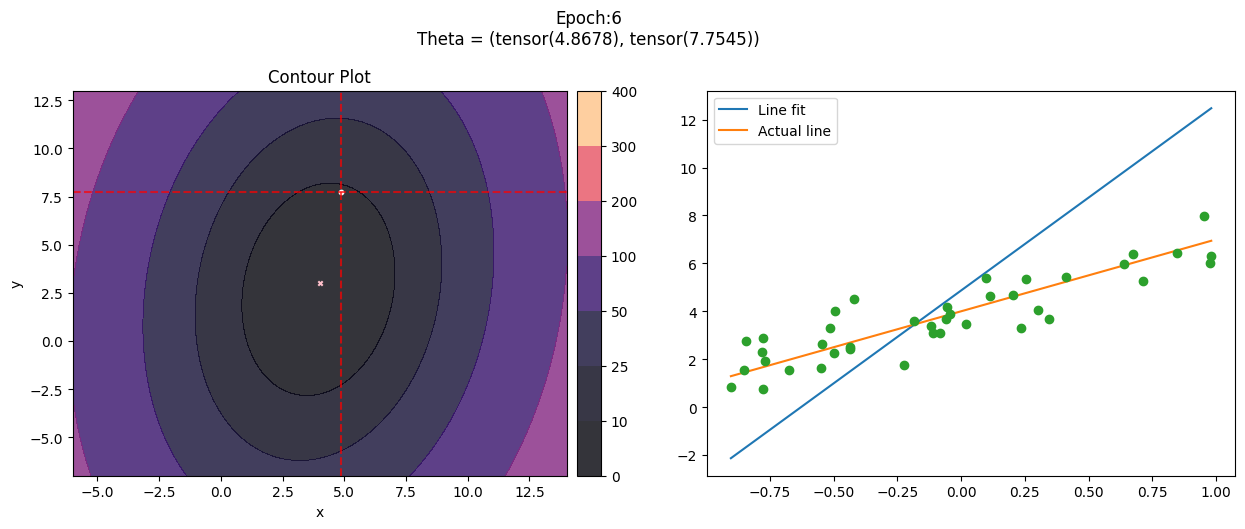

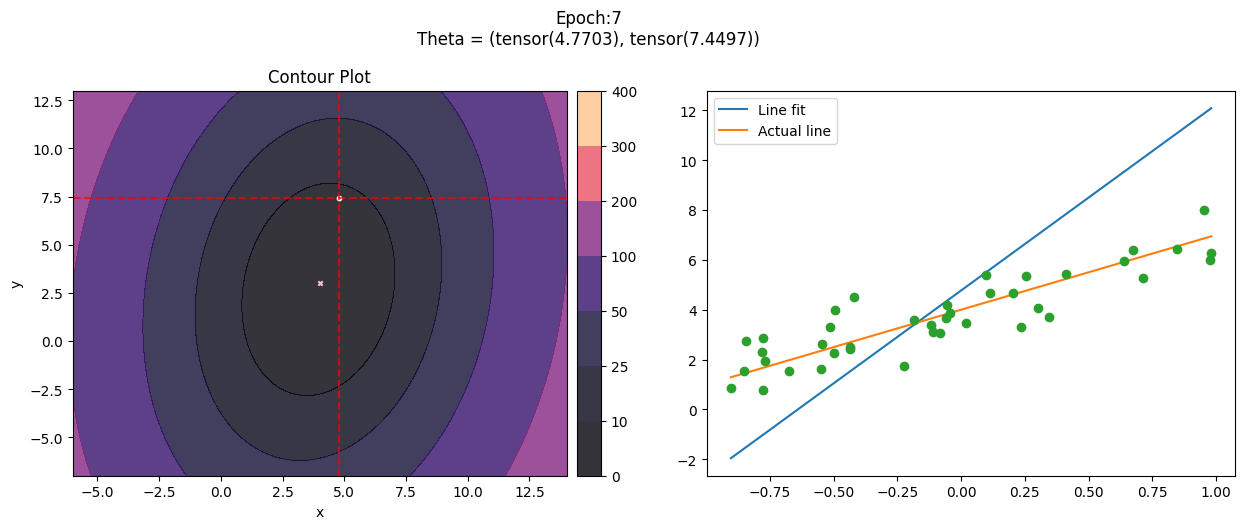

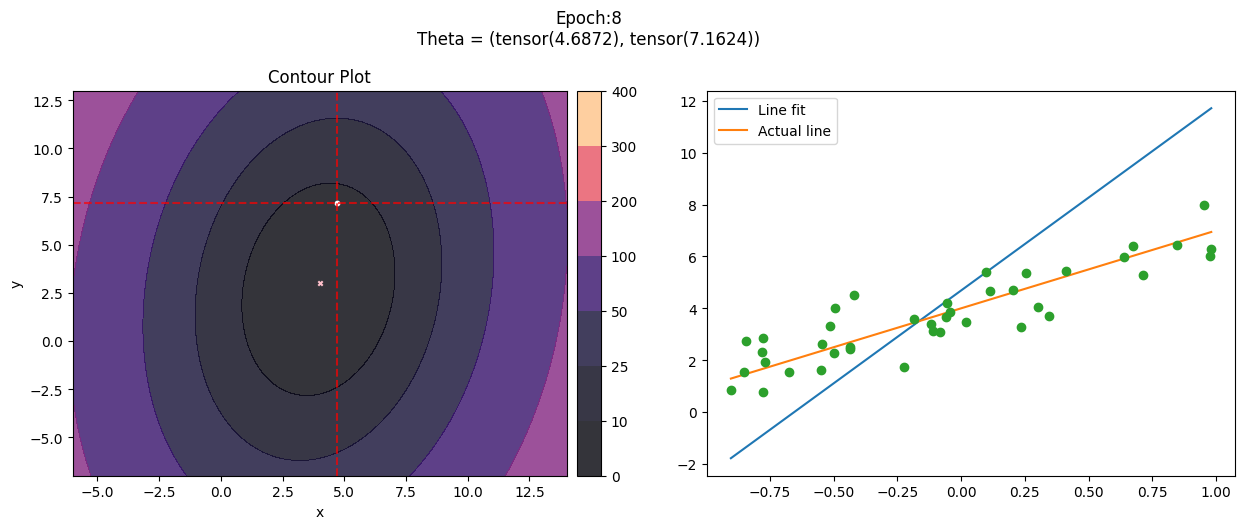

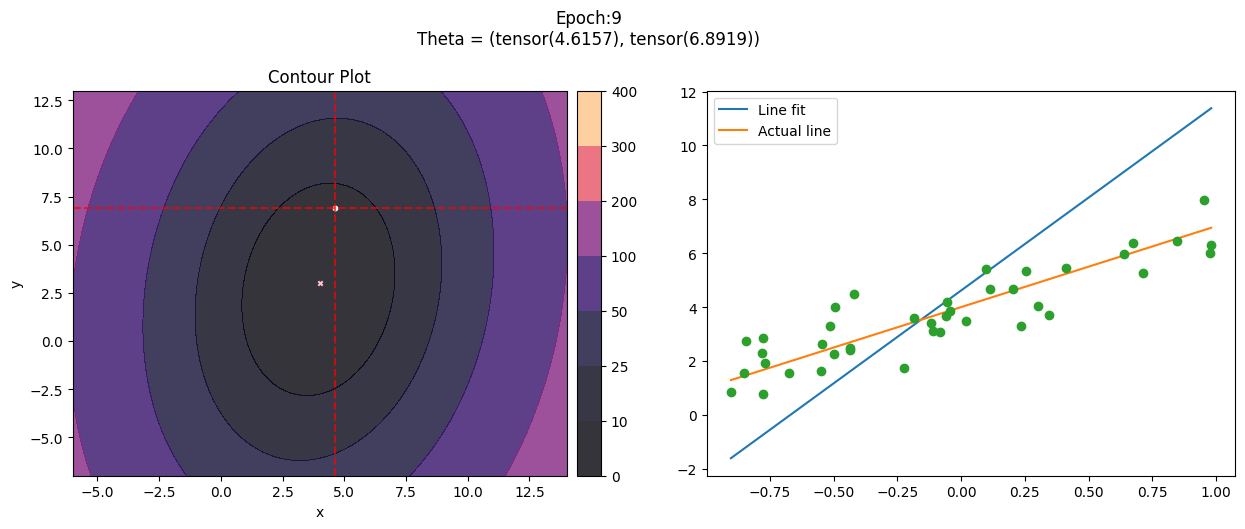

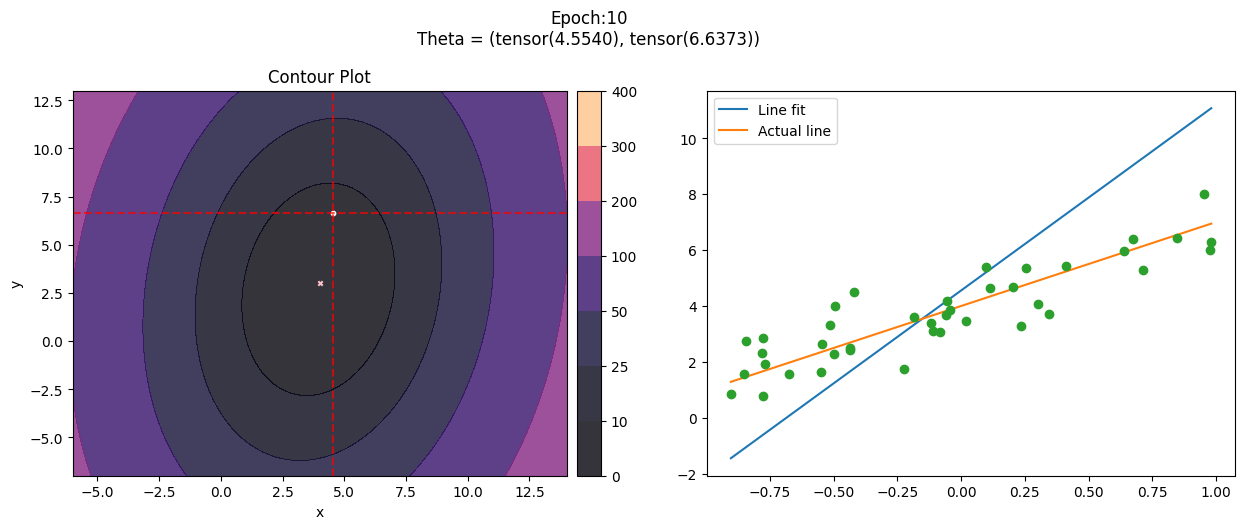

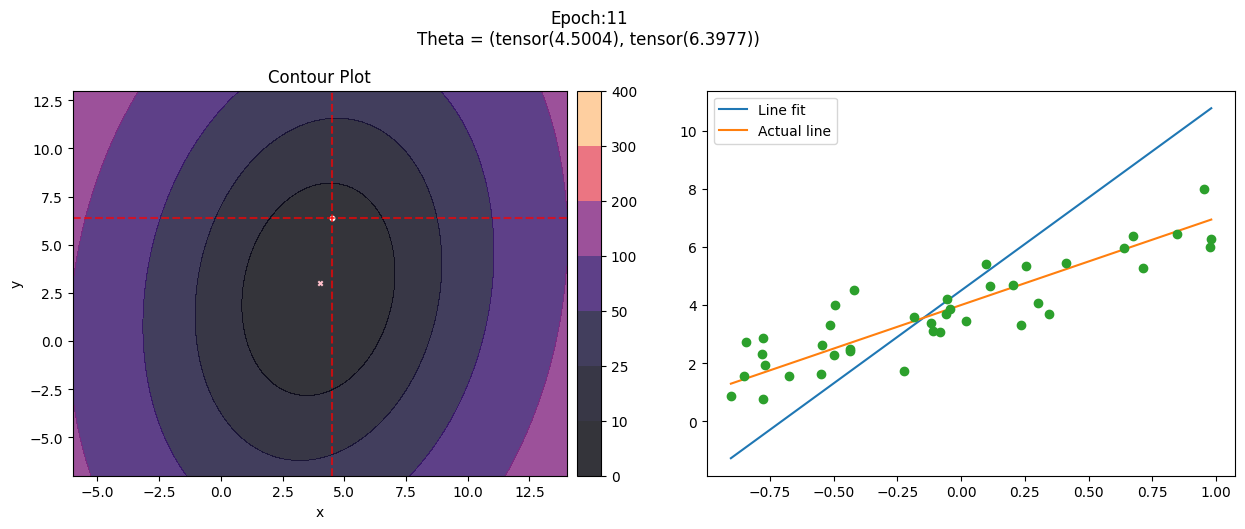

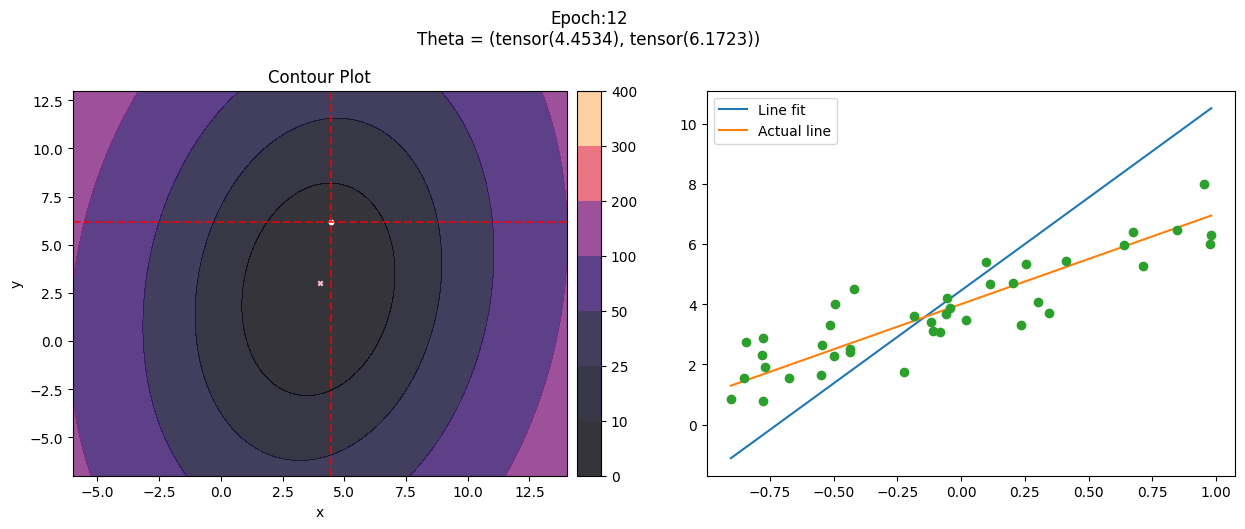

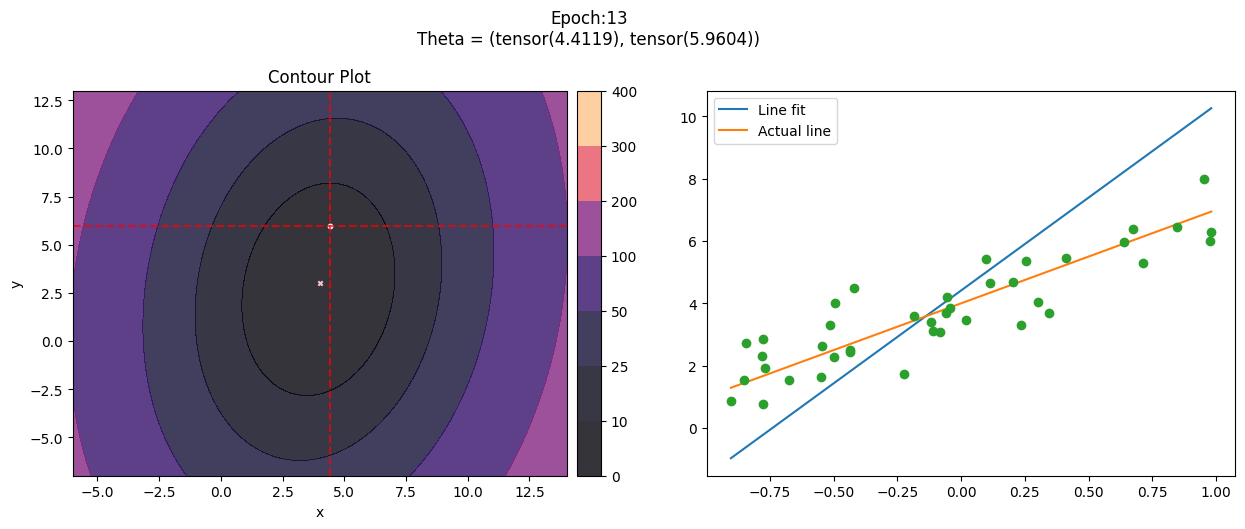

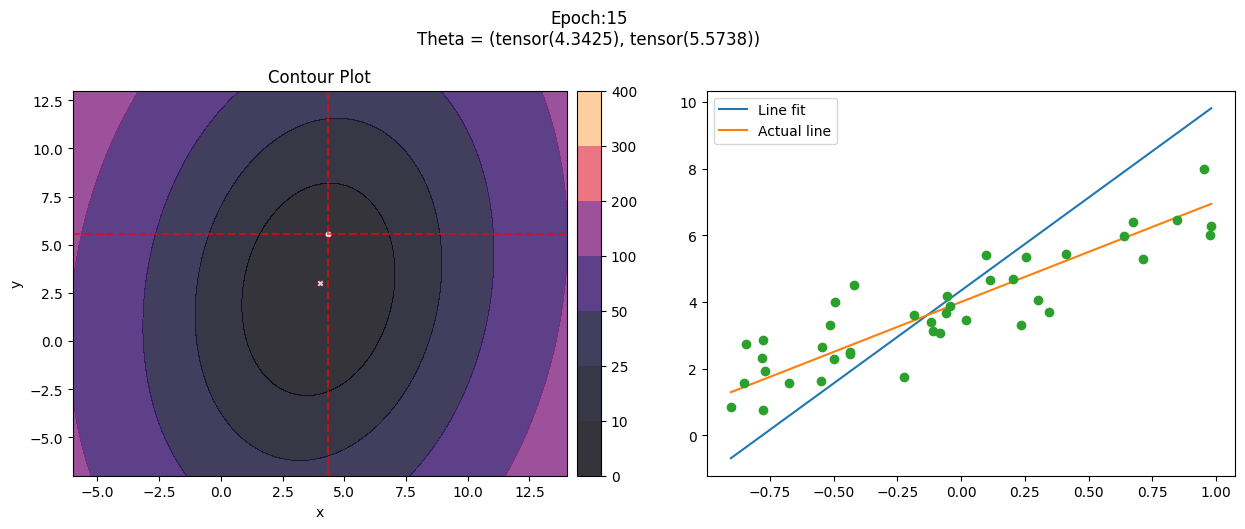

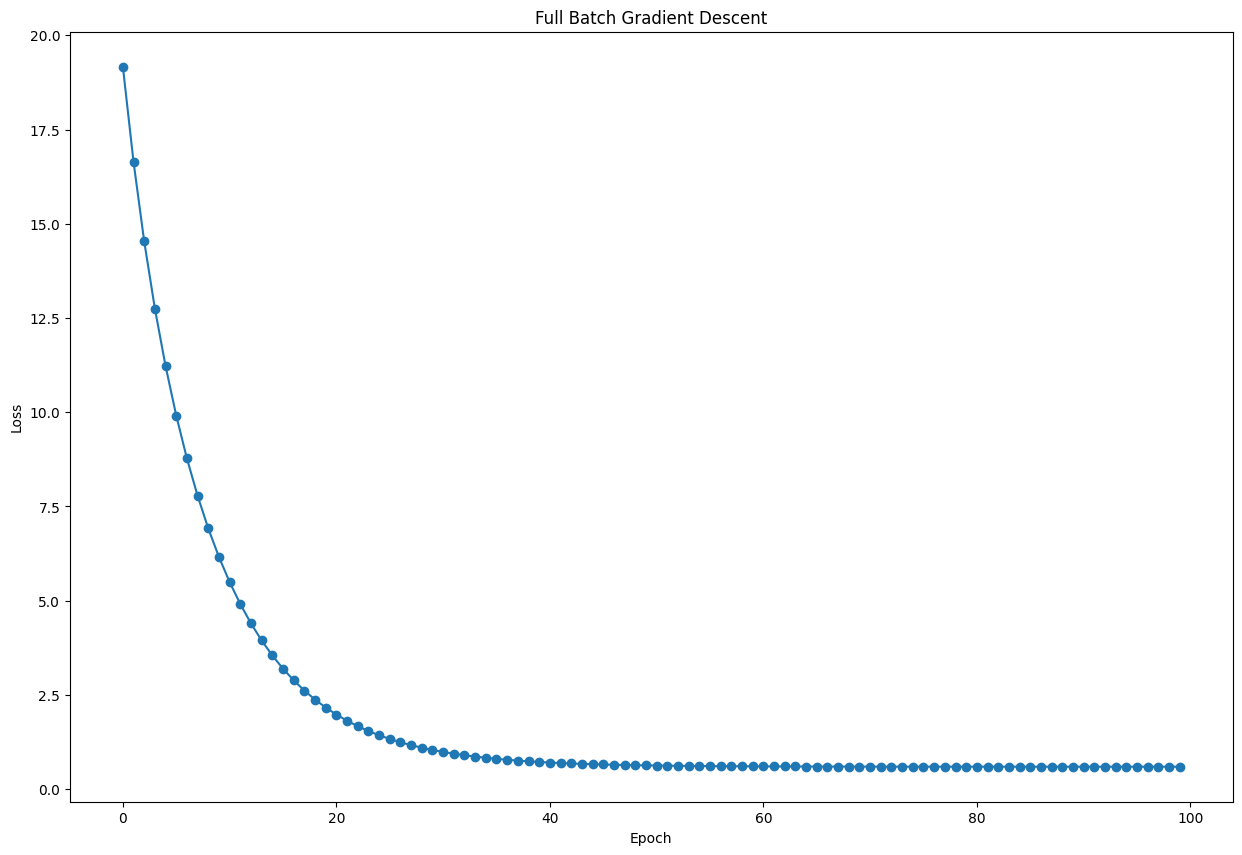

In [14]:
epoch_FBG, loss_FBG=FBG(X1_tensor, y_tensor, theta0, theta1, 4, 3, a, epoch, loss_func)

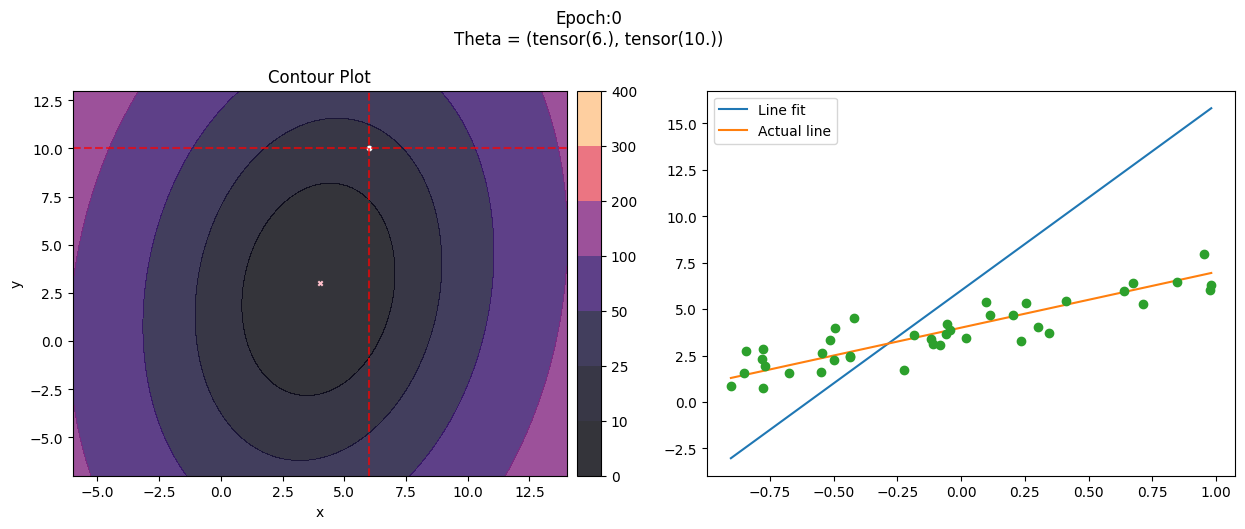

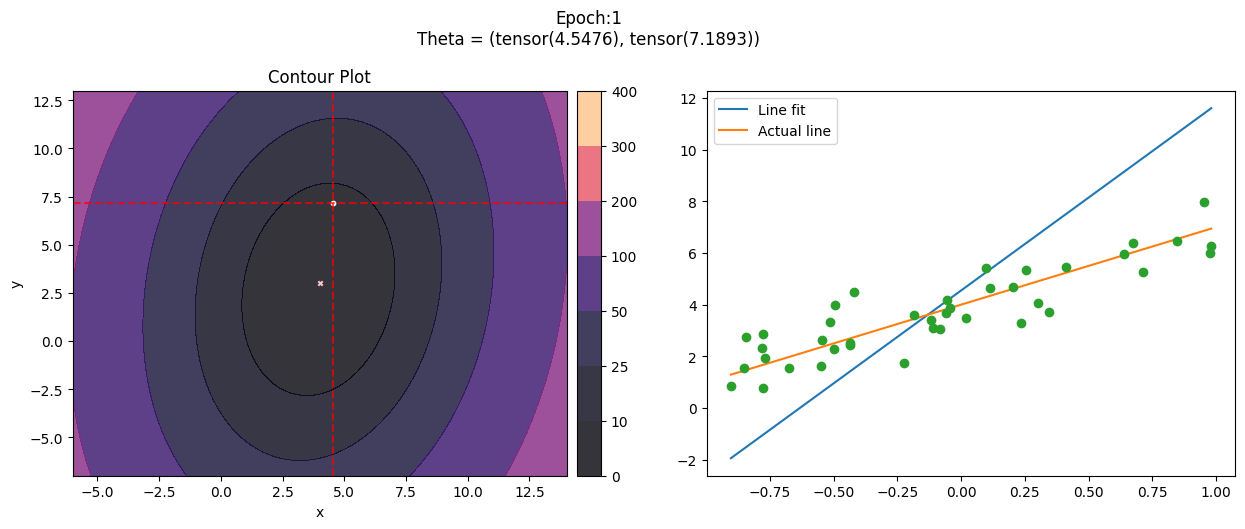

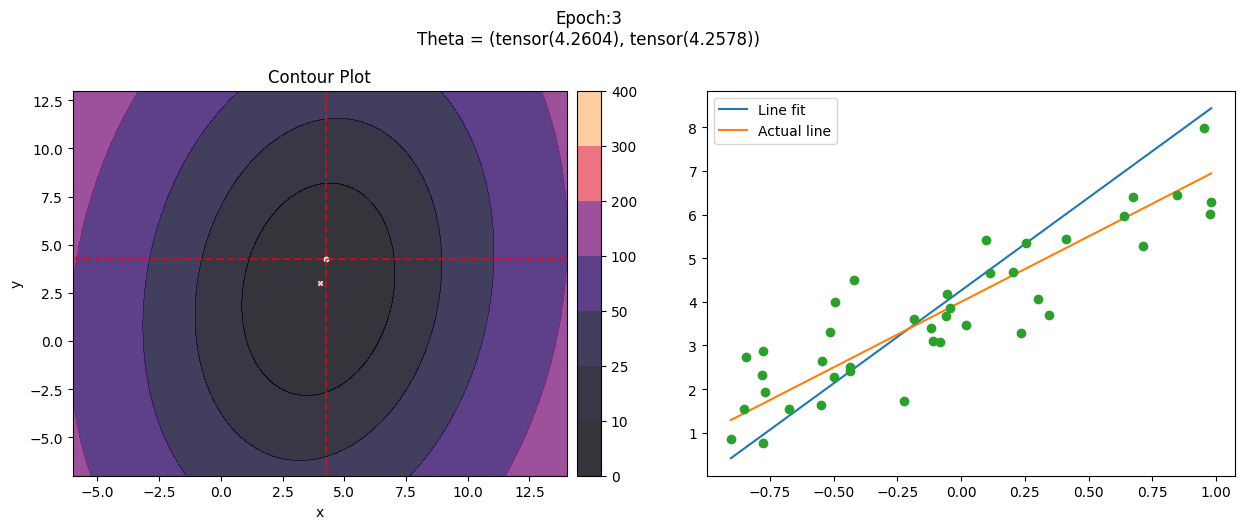

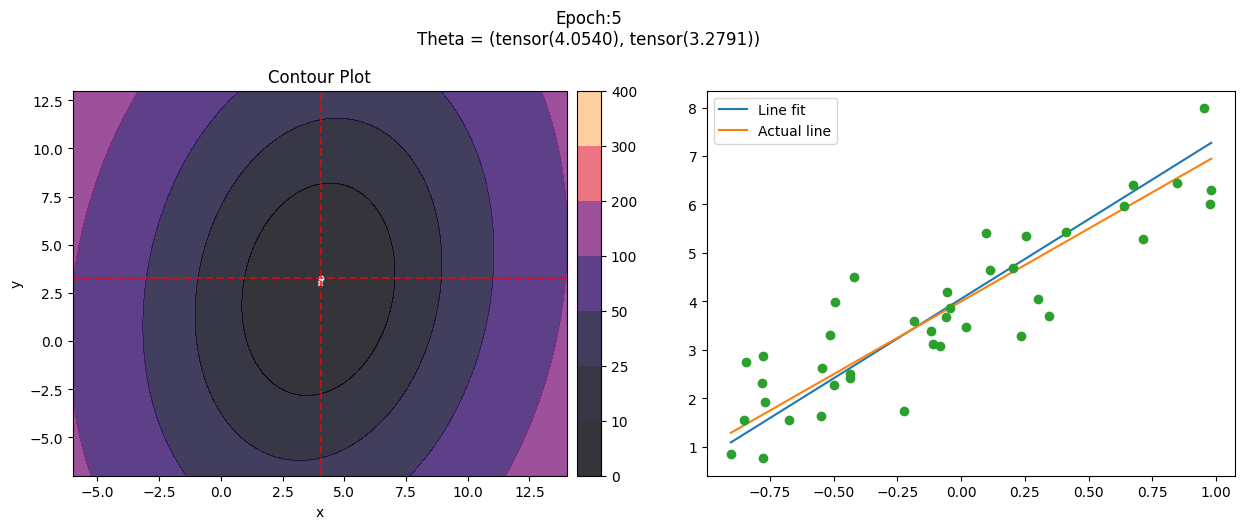

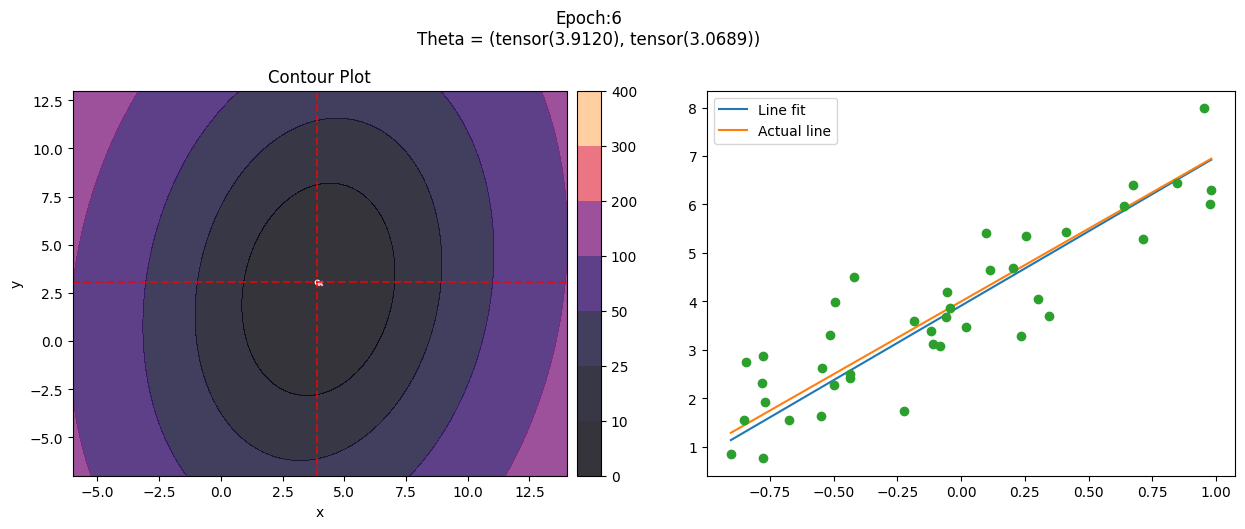

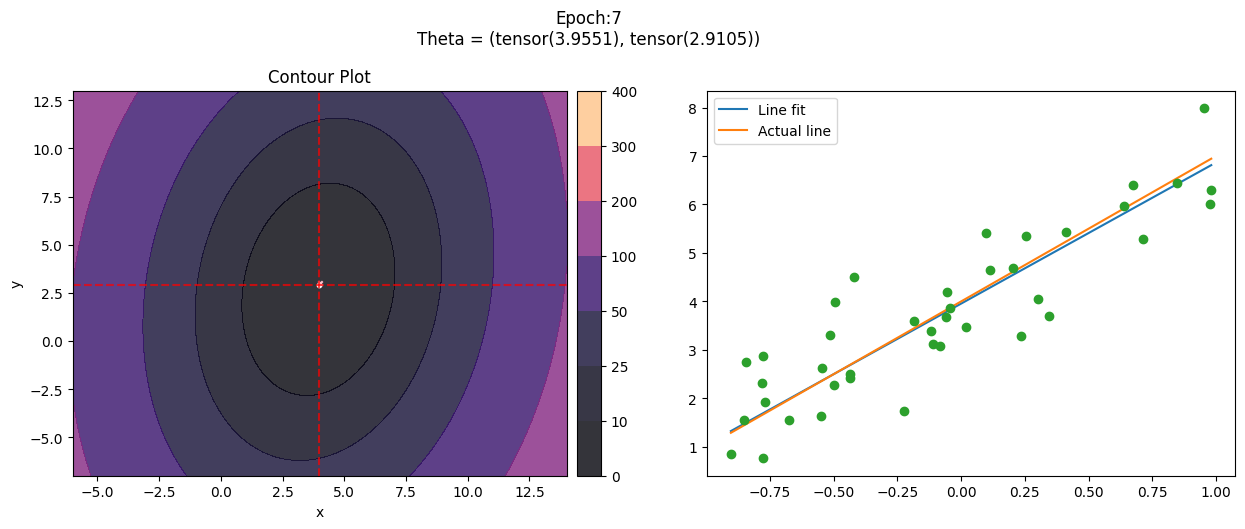

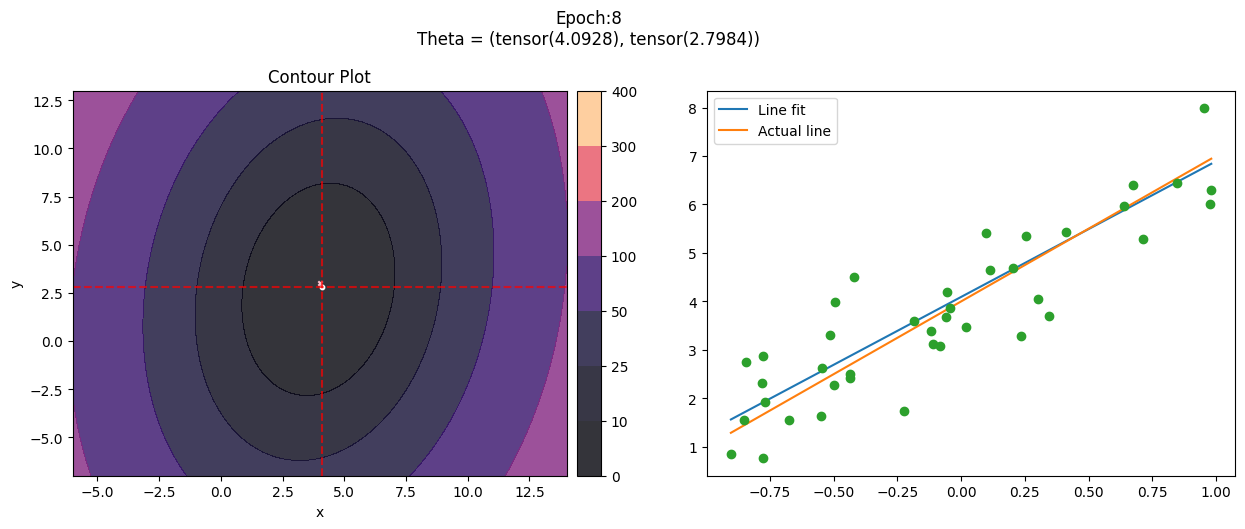

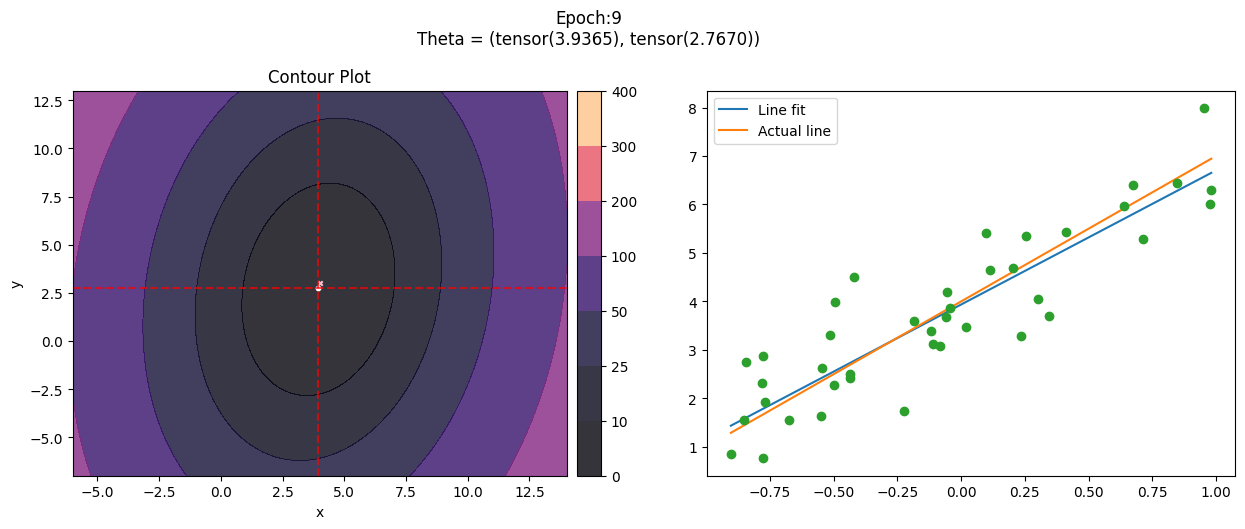

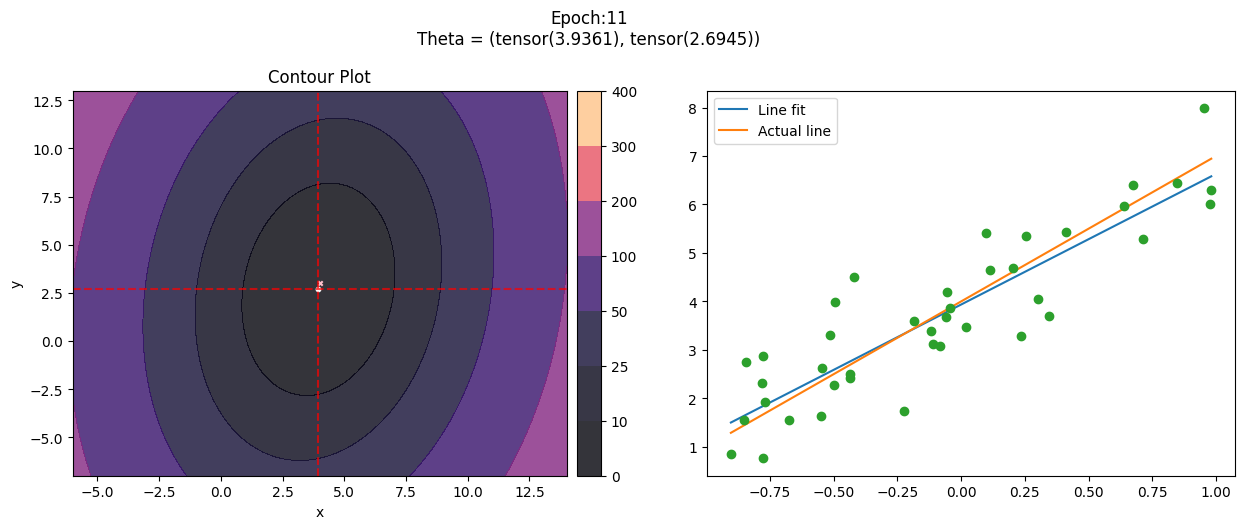

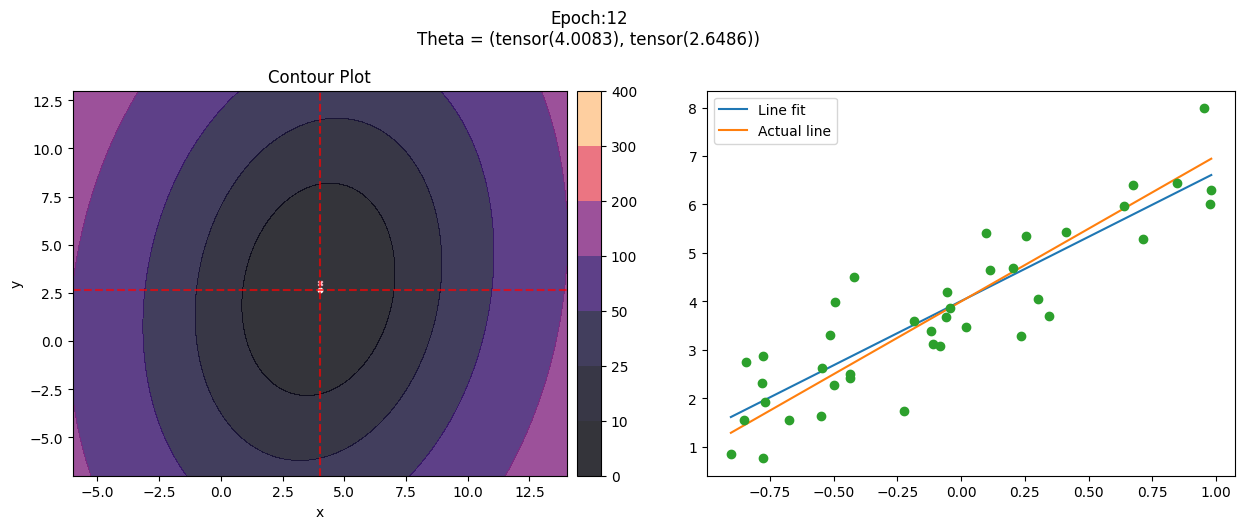

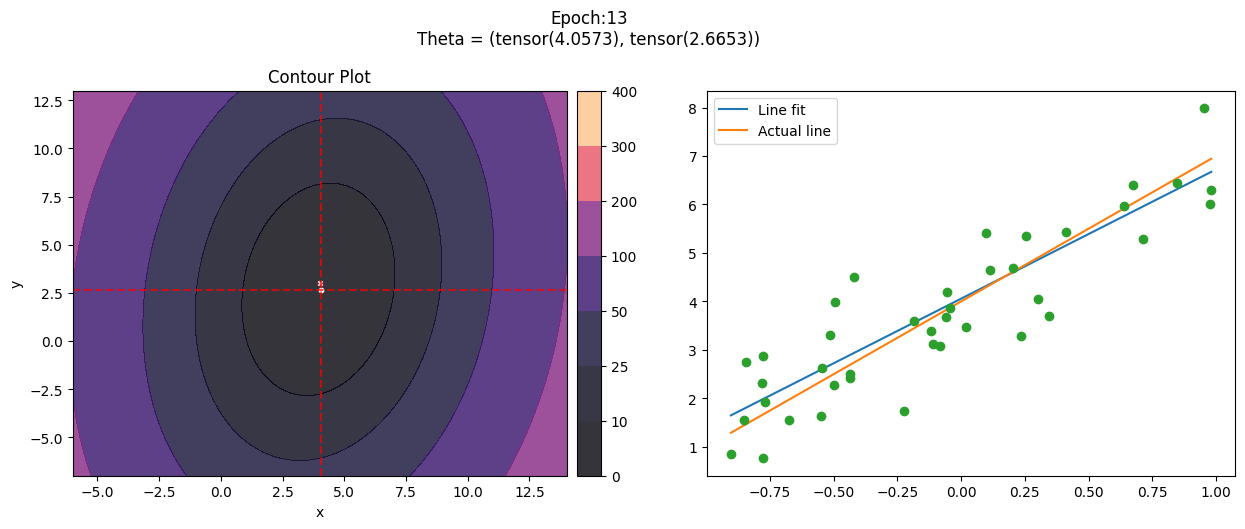

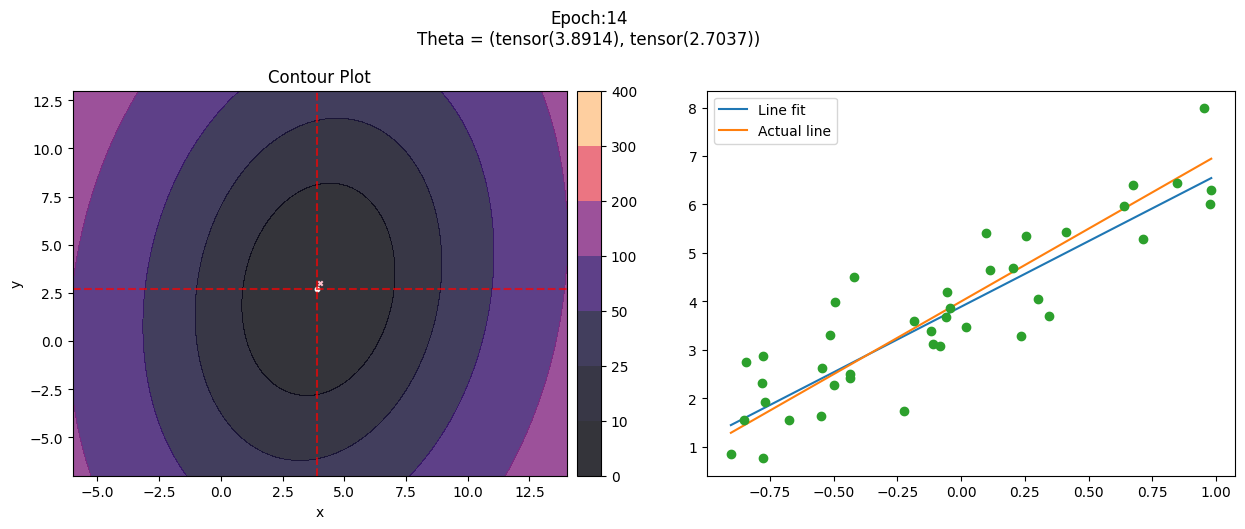

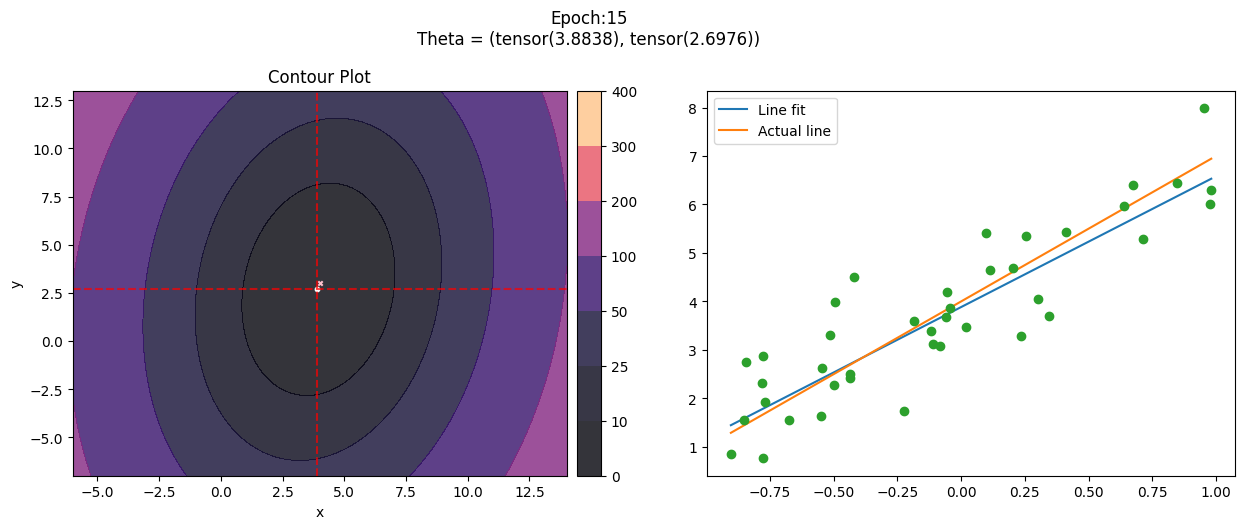

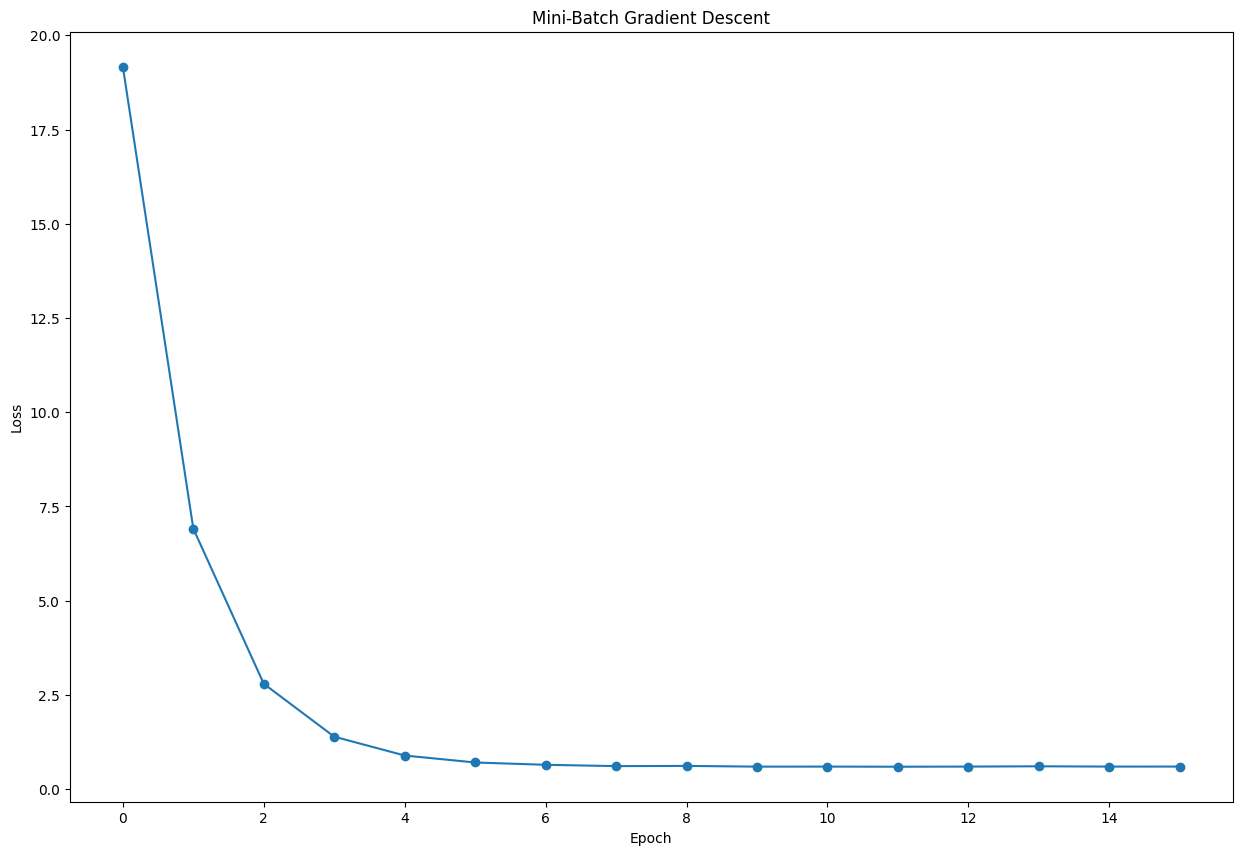

In [22]:
epoch_MBGD, loss_MBGD=MBGD(X1_tensor, y_tensor, theta0, theta1, 4, 3, a, epoch,5, loss_func)

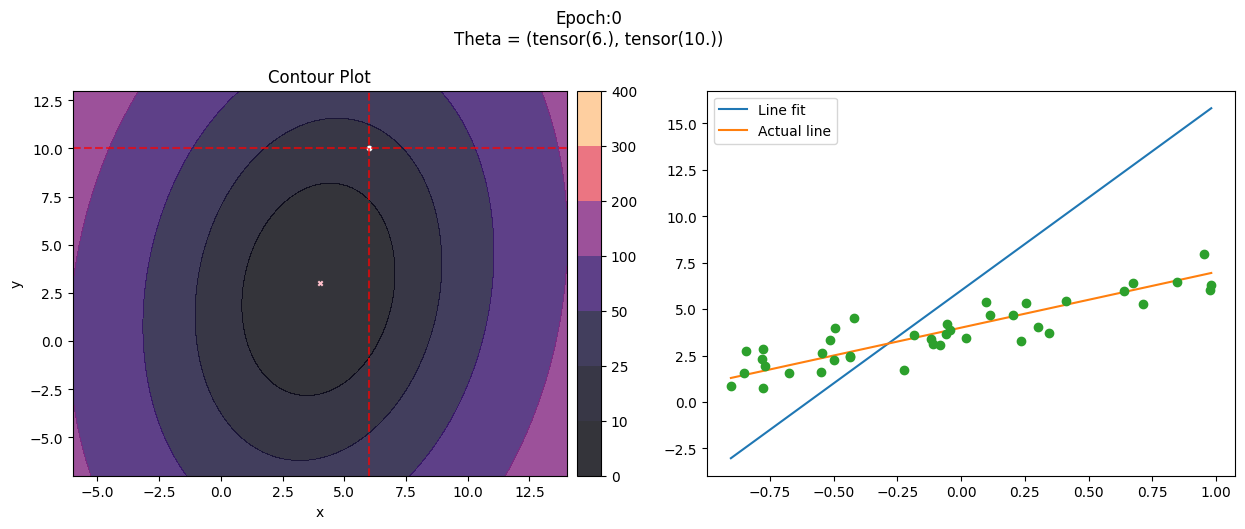

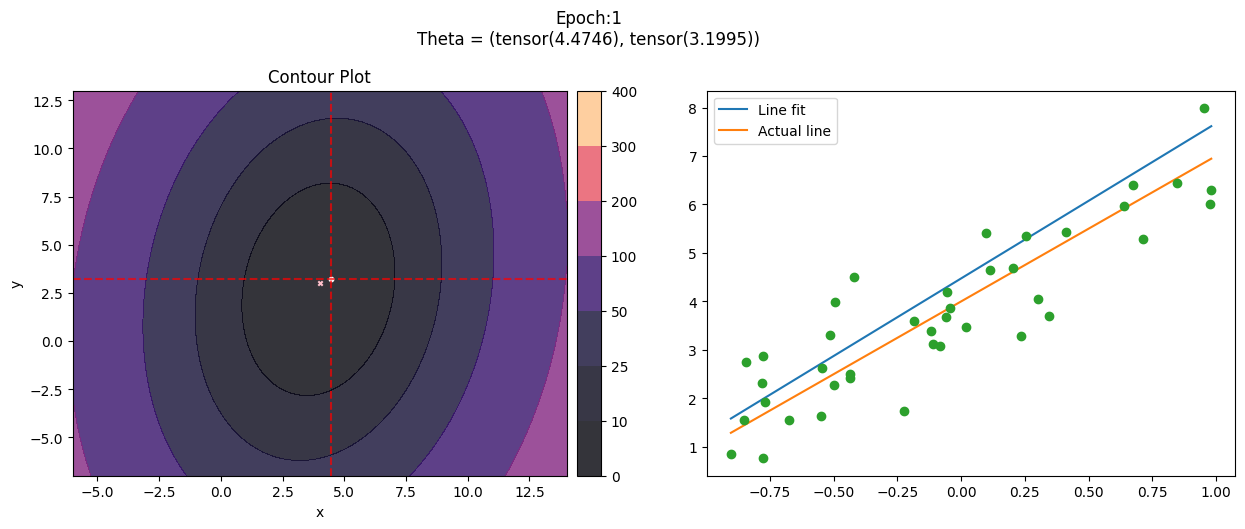

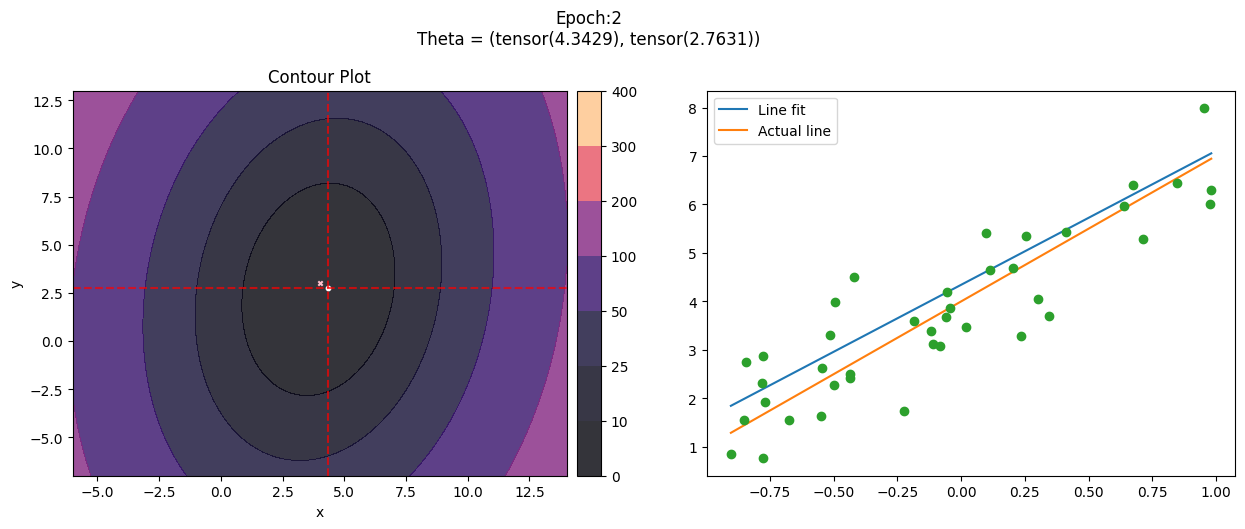

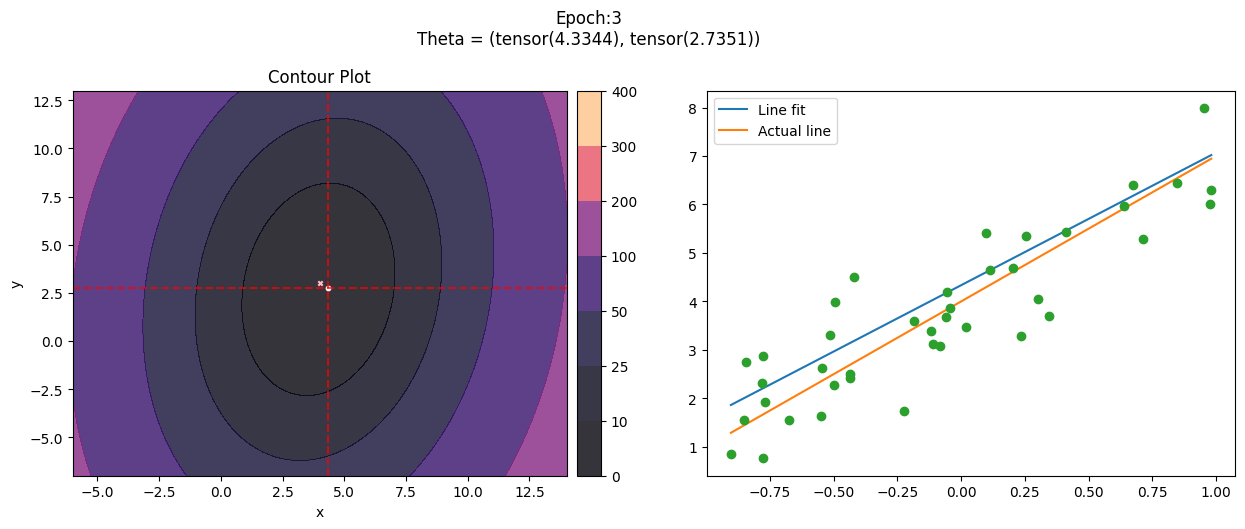

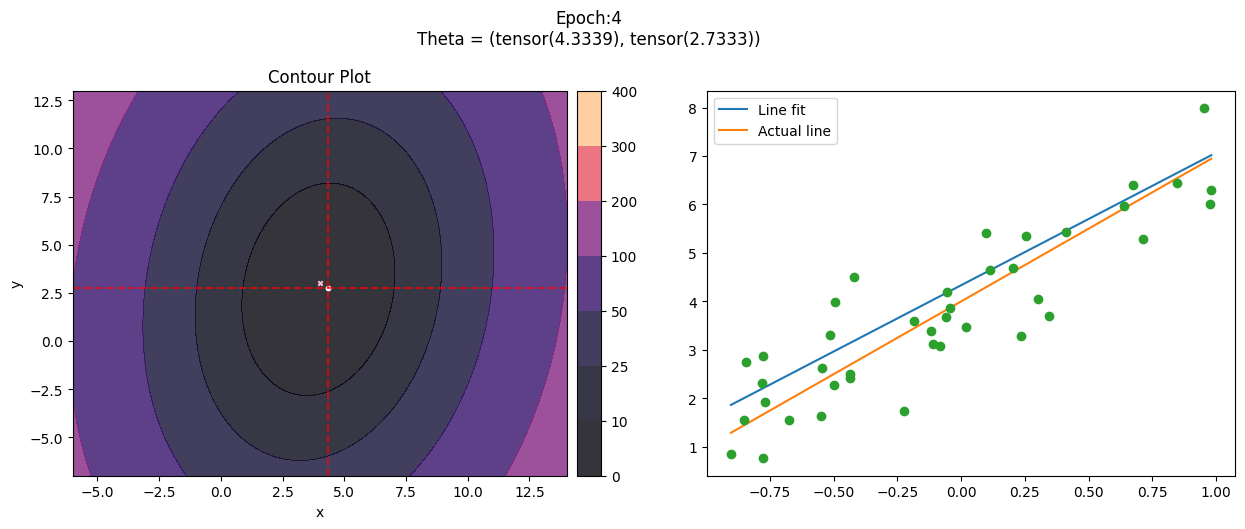

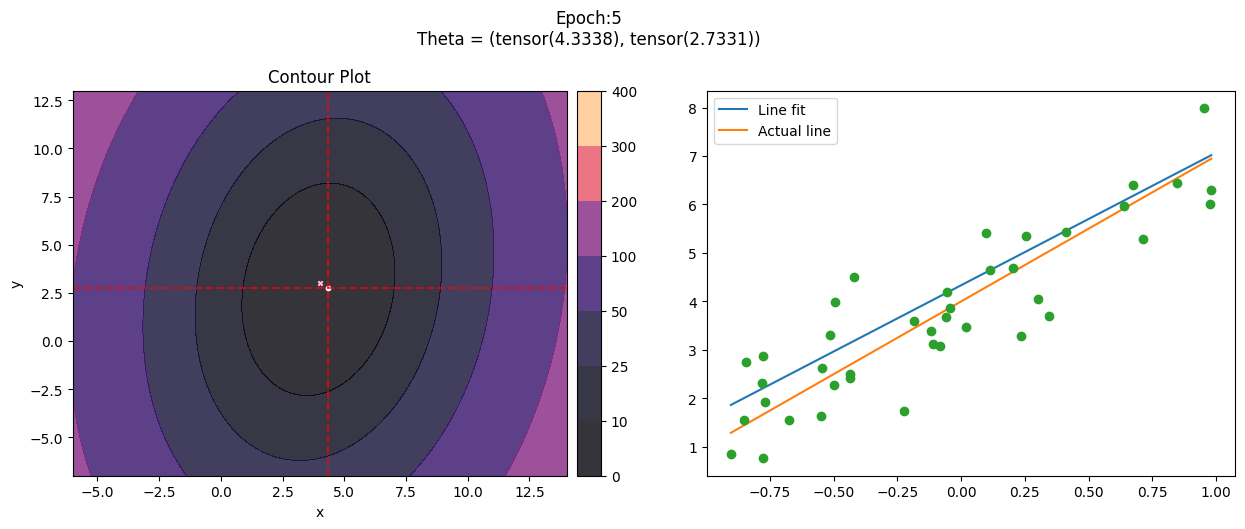

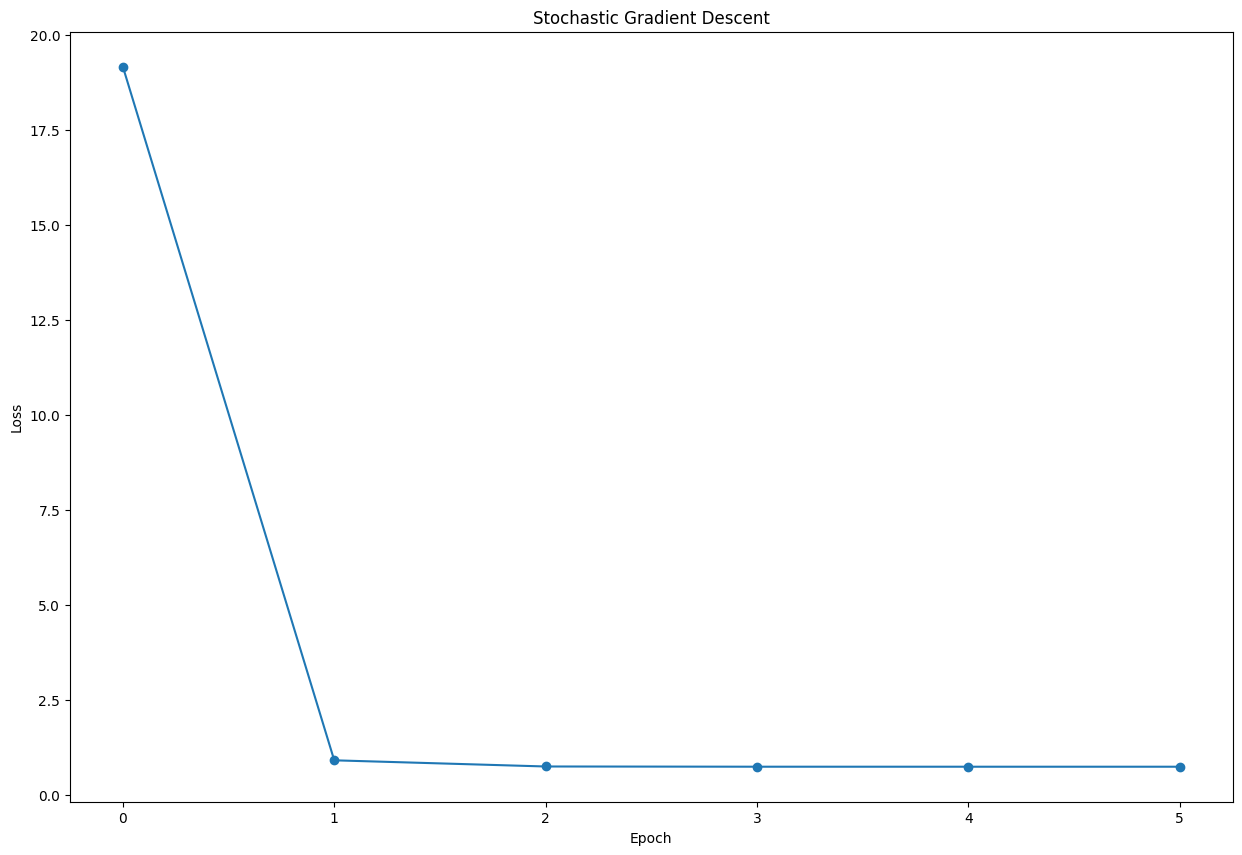

In [17]:
epoch_SGD, loss_SGD=SGD(X1_tensor, y_tensor, theta0, theta1, 4, 3, a, epoch, loss_func)

PART 4

In [16]:
#FULL BATCH WITH MOMENTUM
def FBD_momentum(X, y, theta0, theta1, theta0_true, theta1_true, a, momentum, epoch, loss_fx):
    plt.rcParams['figure.figsize'] = [15, 5]
    # with_latex(columns=2, fig_width=6.5, fig_height=3)
    theta0_data, theta1_data, Z, theta0_data_torch, theta1_data_torch = create_XYZ(loss_fx, X, y,theta0_true, theta1_true)
    levels = [0, 10, 25, 50, 100, 200, 300, 400]
    loss=[loss_fx(theta0, theta1, X, y)]
    epoch_lst=[0]
    theta0_i = theta0
    theta1_i = theta1
    change0=0
    change1=0
    fig, ax = plt.subplots(ncols=2)
    _,_ = create_contour(theta0_data, theta1_data, Z, ax[0], alpha=0.8, scatter_pts=(theta0_i, theta1_i), filled=True, levels=levels)
    # Mark the minima with horizontal and vertical lines
    ax[0].axhline(y=theta1_i, color='red', linestyle='--', alpha=0.7)
    ax[0].axvline(x=theta0_i, color='red', linestyle='--', alpha=0.7)
    ax[0].scatter([theta0_true], [theta1_true], s=10, c='pink', marker='x', label='Minima')
    # plot the line fit
    x_line = np.linspace(X.min(), X.max(), 100)
    y_line = theta0_i + theta1_i*x_line
    y_true = theta1_true*x_line + theta0_true
    ax[1].plot(x_line, y_line, label='Line fit')
    ax[1].plot(x_line, y_true, label='Actual line')
    ax[1].plot(X, y, 'o')
    ax[1].legend()
    plt.title(f'Epoch:{0}\nTheta = {(theta0_i, theta1_i)}',y=1.1)
    for i in range(200):
        theta0_prev, theta1_prev = theta0_i, theta1_i
        gradient=torch.func.grad(loss_fx, argnums=(0, 1))
        del_theta0, del_theta1 = gradient(theta0_i, theta1_i, X, y)
        new_change0=a*del_theta0 + momentum*change0
        new_change1=a*del_theta1 + momentum*change1
        theta0_i = theta0_i - new_change0
        theta1_i = theta1_i - new_change1
        change0, change1 = new_change0, new_change1
        if i<epoch:
            fig, ax = plt.subplots(ncols=2)
            _,_= create_contour(theta0_data, theta1_data, Z, ax[0], alpha=0.8, scatter_pts=(theta0_i, theta1_i), filled=True, levels=levels)
            # Mark the minima with horizontal and vertical lines
            ax[0].axhline(y=theta1_i, color='red', linestyle='--', alpha=0.7)
            ax[0].axvline(x=theta0_i, color='red', linestyle='--', alpha=0.7)
            ax[0].scatter([theta0_true], [theta1_true], s=10, c='pink', marker='x', label='Minima')

            # plot the line fit
            x_line = np.linspace(X.min(), X.max(), 100)
            y_line = theta0_i + theta1_i*x_line
            y_true = theta1_true*x_line + theta0_true
            ax[1].plot(x_line, y_line, label='Line fit')
            ax[1].plot(x_line, y_true, label='Actual line')
            ax[1].plot(X, y, 'o')
            ax[1].legend()
            plt.title(f'Epoch:{i+1}\nTheta = {(theta0_i, theta1_i)}\nGradient = {(del_theta0, del_theta1)}\nMomentum = {(change0, change1)}', y=1.1)
        loss.append(loss_fx(theta0_i, theta1_i, X, y))
        epoch_lst.append(i+1)
        if abs(theta0_prev - theta0_i)<0.001 and abs(theta1_prev-theta1_i)<0.001:
            break

    plt.figure(figsize=(15, 10))
    plt.plot(epoch_lst, loss, '-o')
    plt.title('Full Batch Gradient Descent with Momentum')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    epochs_FBD=epoch_lst
    loss_FBD=loss
    return epochs_FBD, loss_FBD

In [18]:
#STOCHASTIC GRADIENT DESCENT
def SGD_momentum(X, y, theta0, theta1, theta0_true, theta1_true,a, momentum, epoch, loss_fx):
    plt.rcParams['figure.figsize'] = [15, 5]
    # with_latex(columns=2, fig_width=6.5, fig_height=3)
    theta0_data, theta1_data, Z, theta0_data_torch, theta1_data_torch = create_XYZ(loss_fx, X, y,theta0_true, theta1_true)
    levels = [0, 10, 25, 50, 100, 200, 300, 400]
    loss = [loss_fx(theta0, theta1, X, y)]
    epoch_lst=[0]
    theta0_i = theta0
    theta1_i = theta1
    change0=0
    change1=0
    fig, ax = plt.subplots(ncols=2)
    _,_ = create_contour(theta0_data, theta1_data, Z, ax[0], alpha=0.8, scatter_pts=(theta0_i, theta1_i), filled=True, levels=levels)
    # Mark the minima with horizontal and vertical lines
    ax[0].axhline(y=theta1_i, color='red', linestyle='--', alpha=0.7)
    ax[0].axvline(x=theta0_i, color='red', linestyle='--', alpha=0.7)
    ax[0].scatter([theta0_true], [theta1_true], s=10, c='pink', marker='x', label='Minima')
    # plot the line fit
    x_line = np.linspace(X.min(), X.max(), 100)
    y_line = theta0_i + theta1_i*x_line
    y_true = theta1_true*x_line + theta0_true
    ax[1].plot(x_line, y_line, label='Line fit')
    ax[1].plot(x_line, y_true, label='Actual line')
    ax[1].plot(X, y, 'o')
    ax[1].legend()
    plt.title(f'Epoch:{0}\nTheta = {(theta0_i, theta1_i)}',y=1.1)
    for i in range(200):
        theta0_prev, theta1_prev = theta0_i, theta1_i
        for j in range(len(X)):
            del_theta0, del_theta1 = torch.func.grad(loss_fx, argnums=(0, 1))(theta0_i, theta1_i, X[j], y[j])
            new_change0=a*del_theta0 + momentum*change0
            new_change1=a*del_theta1 + momentum*change1
            theta0_i = theta0_i - new_change0
            theta1_i = theta1_i - new_change1
            change0, change1 = new_change0, new_change1
        if i<epoch:
            fig, ax = plt.subplots(ncols=2)
            _,_ = create_contour(theta0_data, theta1_data, Z, ax[0], alpha=0.8, scatter_pts=(theta0_i, theta1_i), filled=True, levels=levels)
            # Mark the minima with horizontal and vertical lines
            ax[0].axhline(y=theta1_i, color='red', linestyle='--', alpha=0.7)
            ax[0].axvline(x=theta0_i, color='red', linestyle='--', alpha=0.7)
            ax[0].scatter([theta0_true], [theta1_true], s=10, c='pink', marker='x', label='Minima')
            # plot the line fit
            x_line = np.linspace(X.min(), X.max(), 100)
            y_line = theta0_i + theta1_i*x_line
            y_true = theta1_true*x_line + theta0_true
            ax[1].plot(x_line, y_line, label='Line fit')
            ax[1].plot(x_line, y_true, label='Actual line')
            ax[1].plot(X, y, 'o')
            ax[1].legend()
            plt.title(f'Epoch:{i+1}\nTheta = {(theta0_i, theta1_i)}\nGradient = {(del_theta0, del_theta1)}\nMomentum = {(change0, change1)}', y=1.1)
        loss.append(loss_fx(theta0_i, theta1_i, X, y))
        epoch_lst.append(i+1)
        if abs(theta0_prev - theta0_i)<0.001 and abs(theta1_prev-theta1_i)<0.001:
            break

    plt.figure(figsize=(15, 10))
    plt.plot(epoch_lst, loss, '-o')
    plt.title('Stochastic Gradient Descent with momentum')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    return epoch_lst, loss


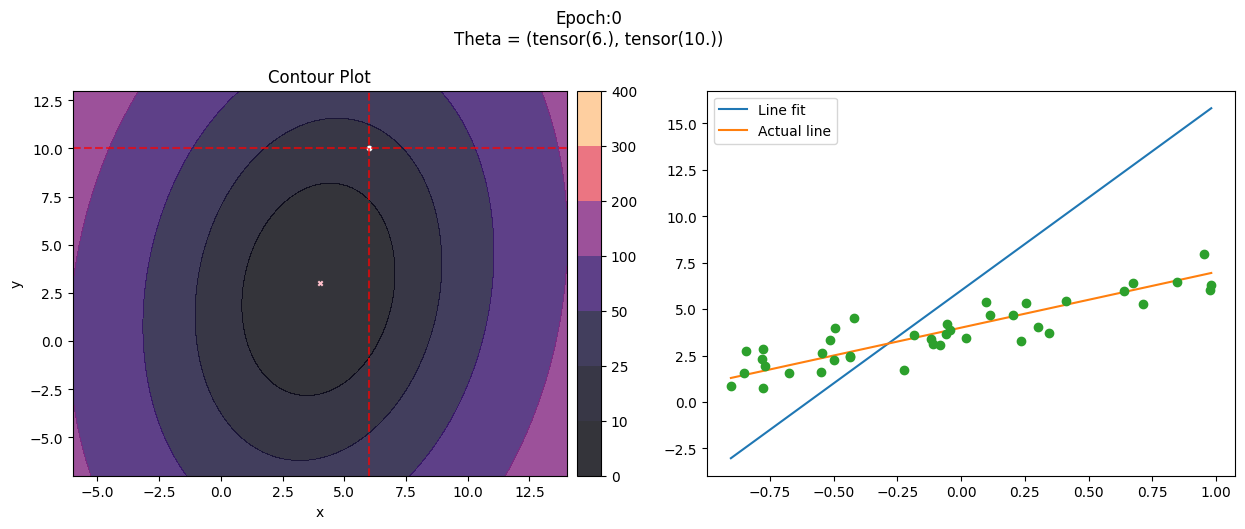

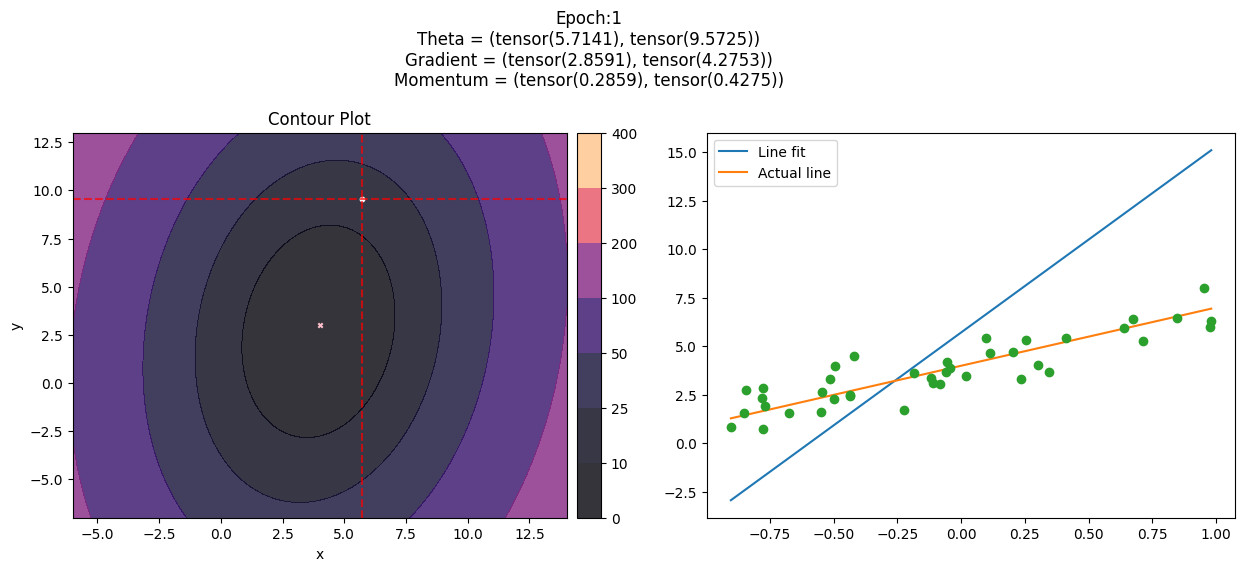

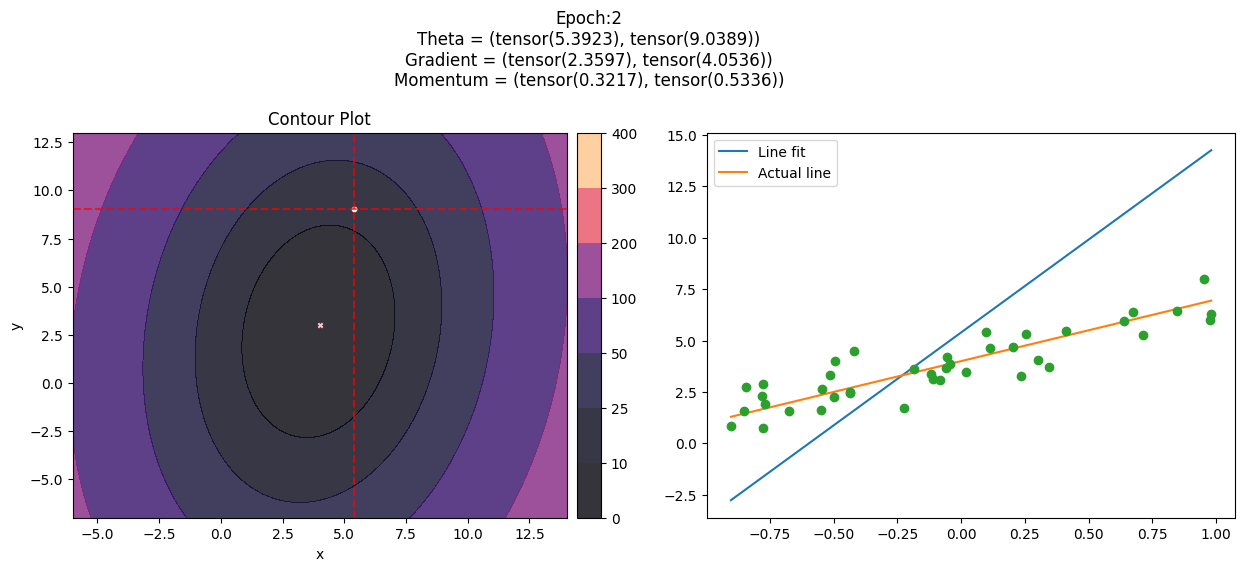

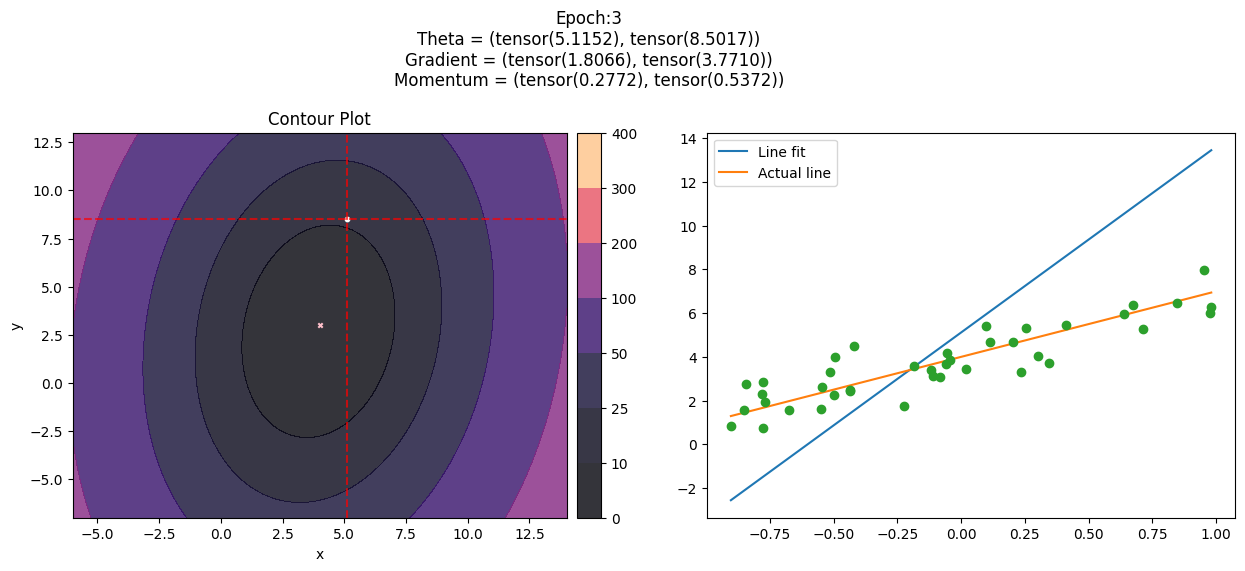

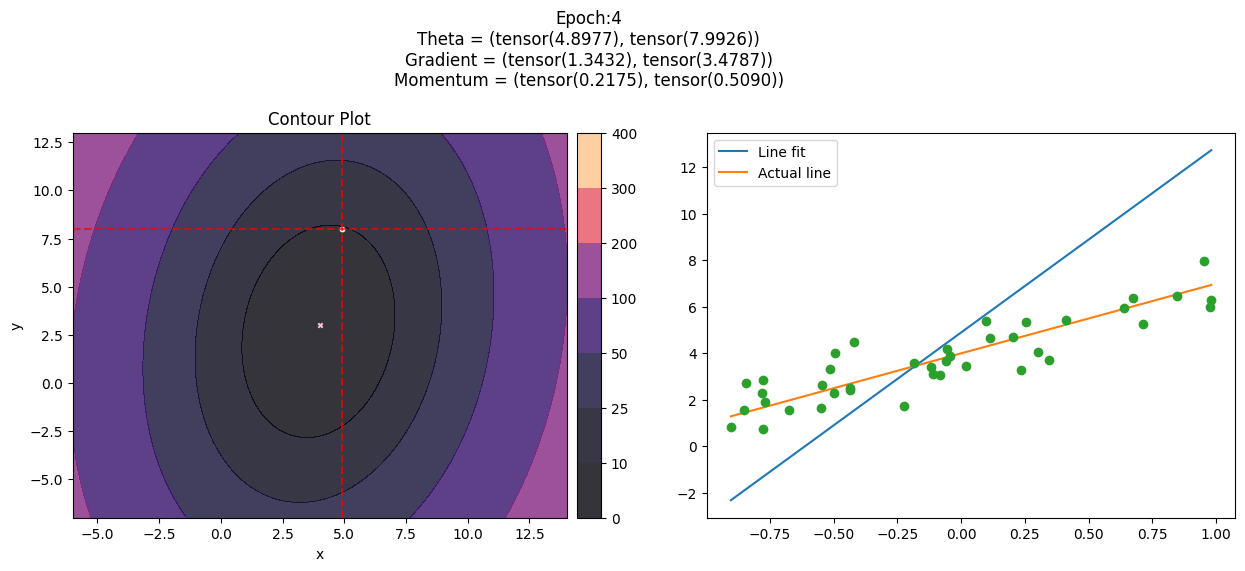

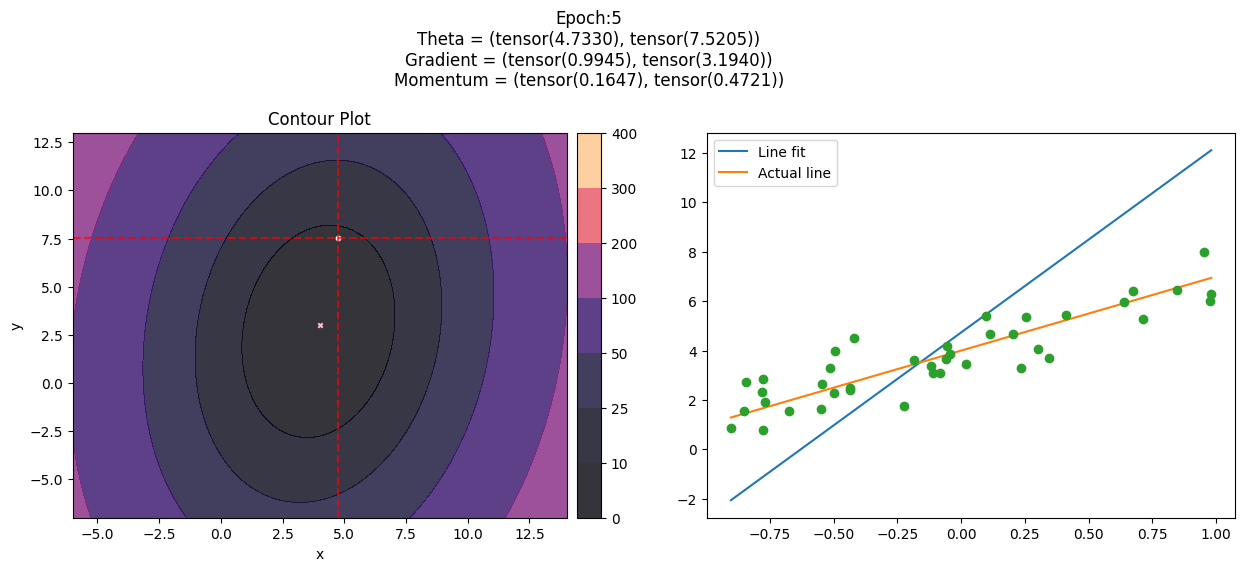

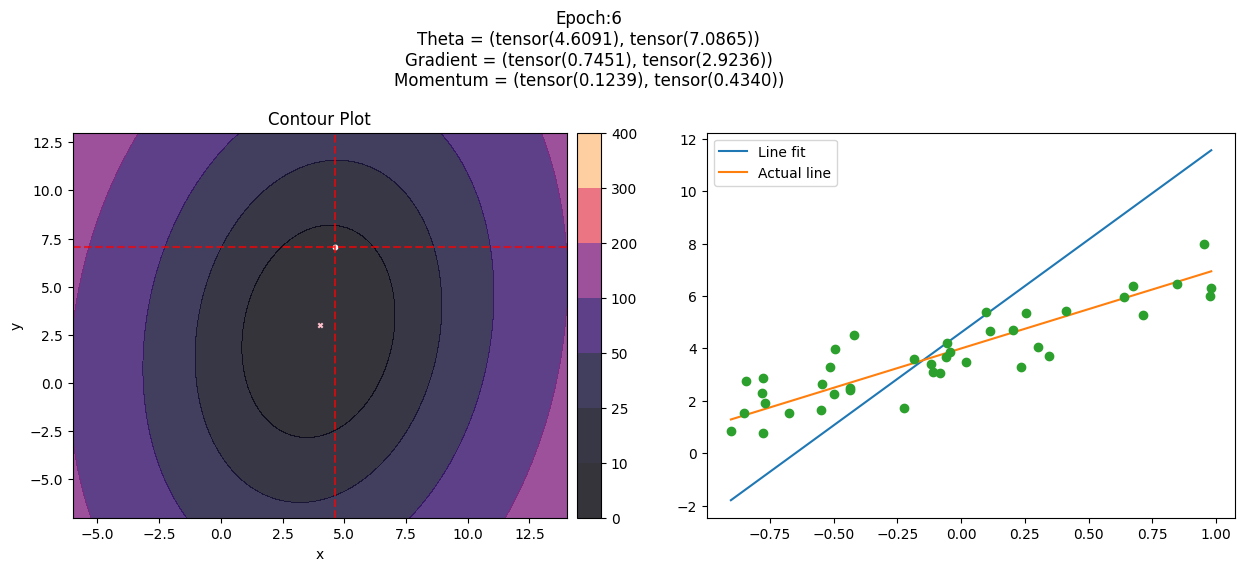

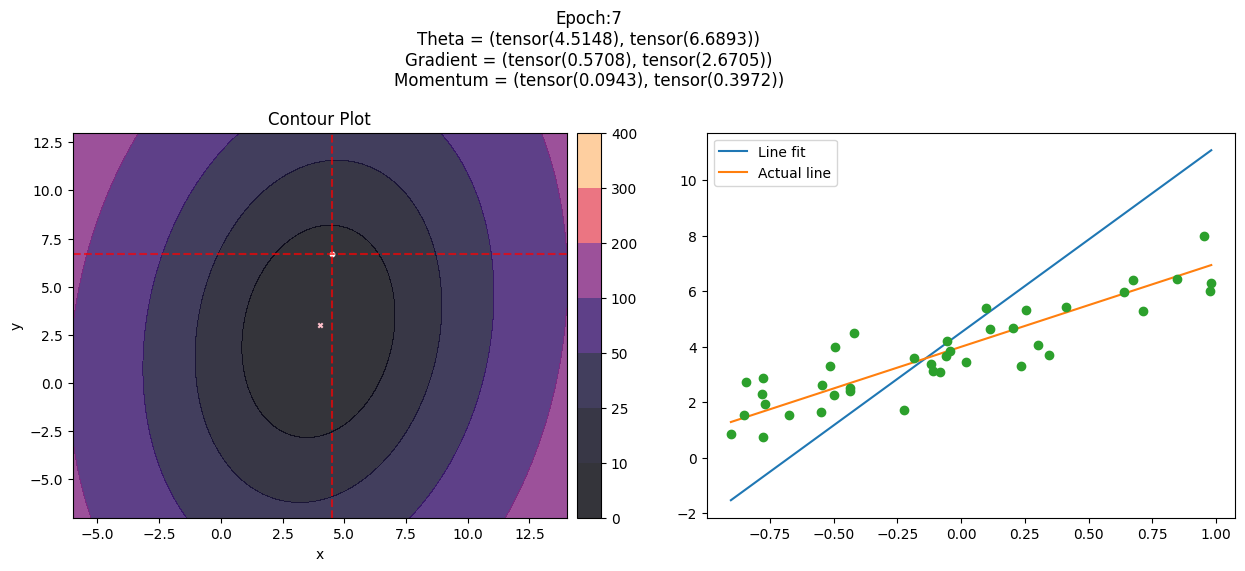

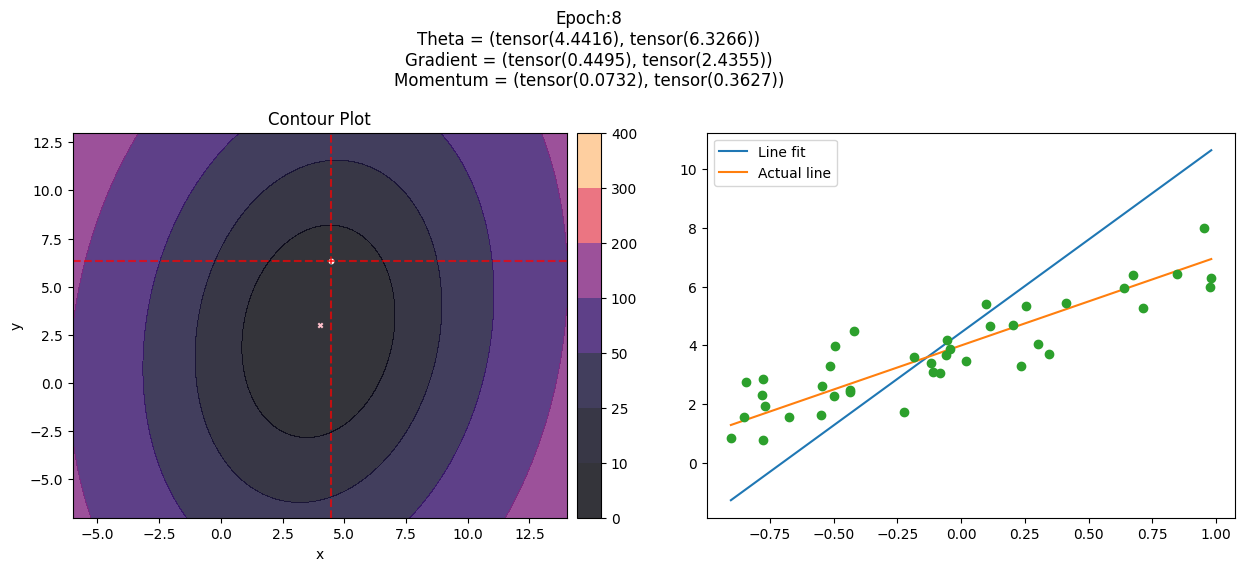

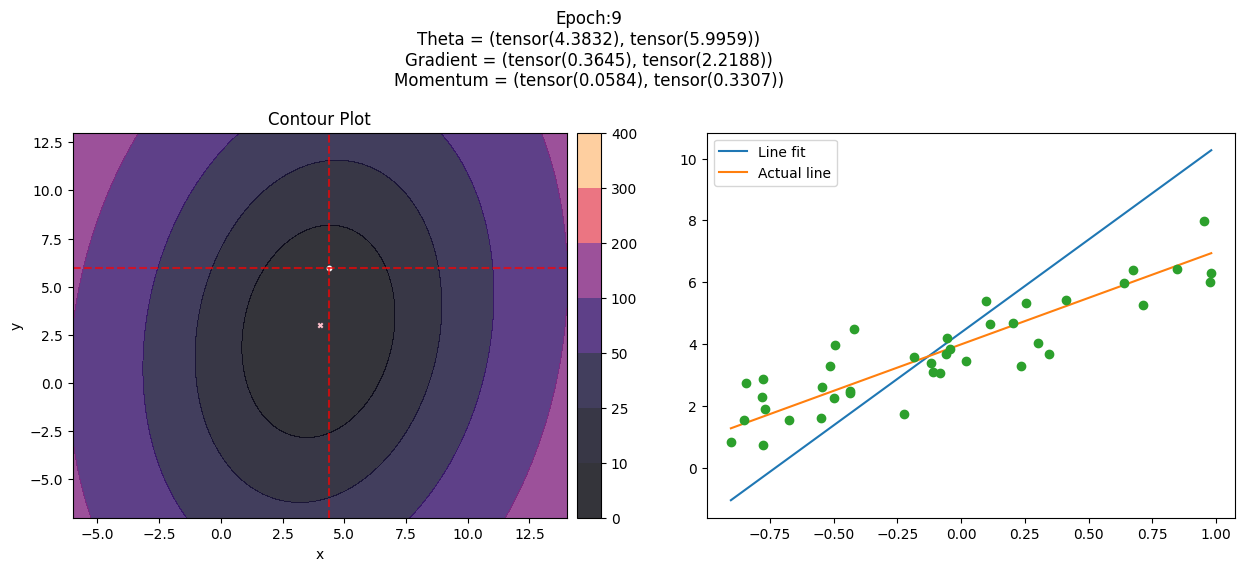

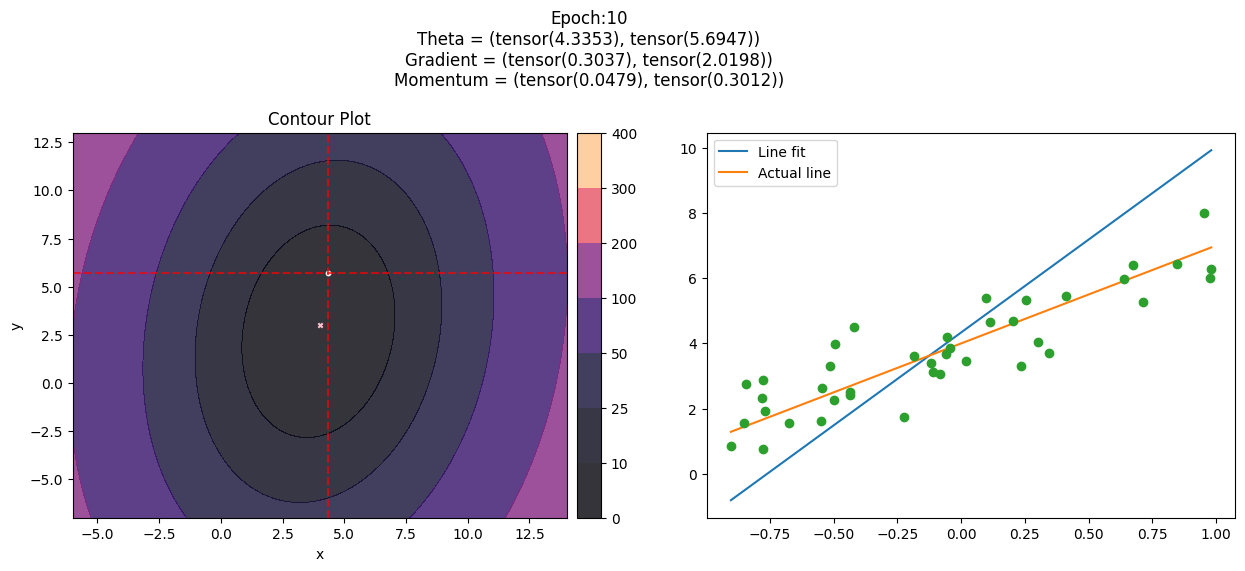

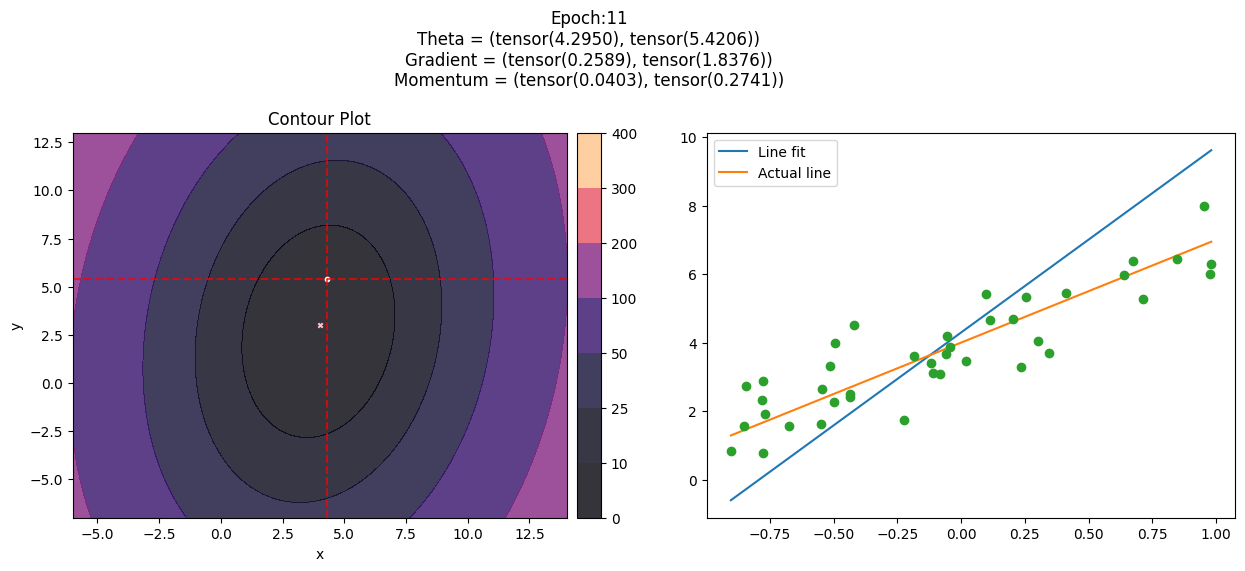

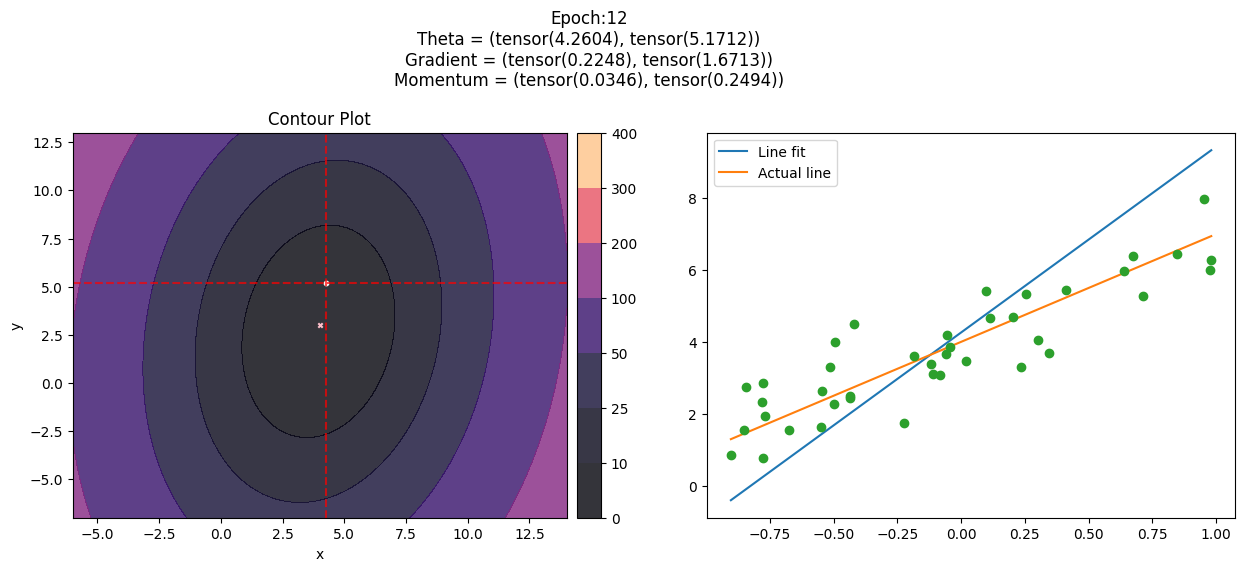

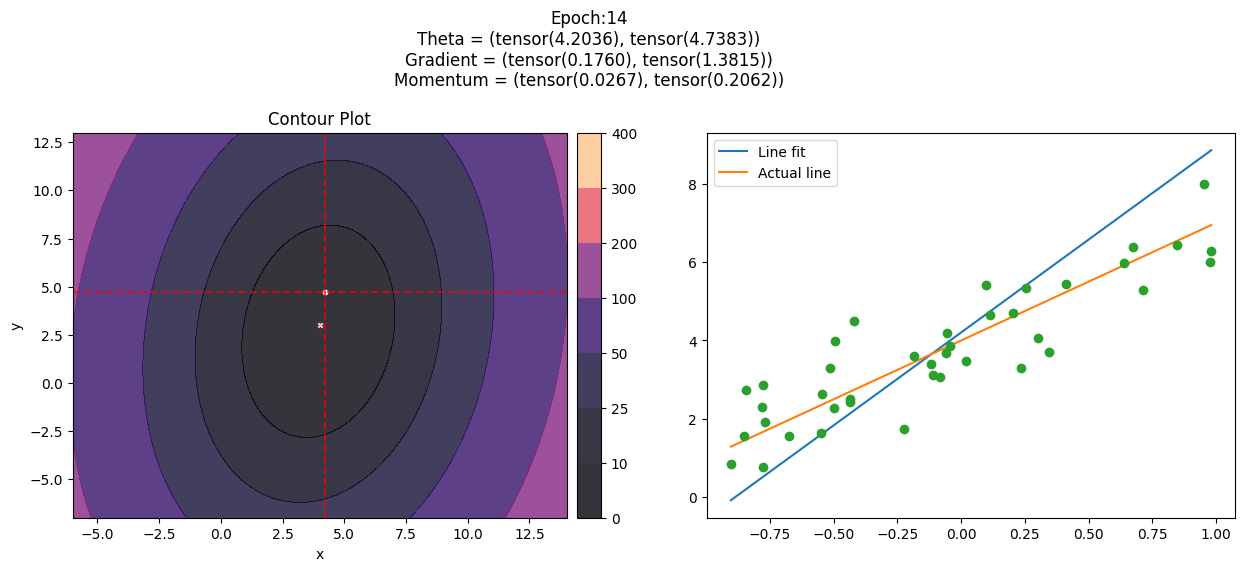

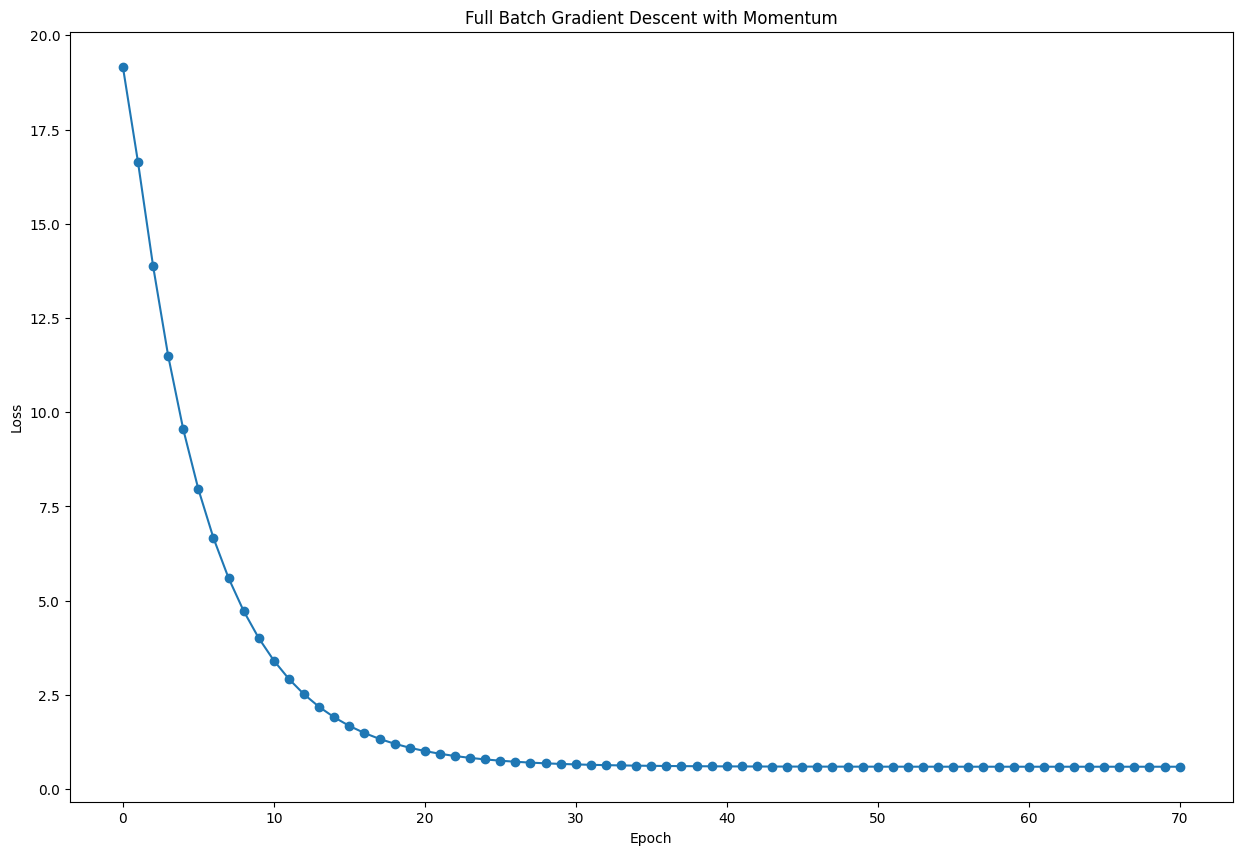

In [19]:
epochs_FBD, loss_FBD2=FBD_momentum(X1_tensor, y_tensor, theta0, theta1, 4, 3, a, momentum, epoch, loss_func)

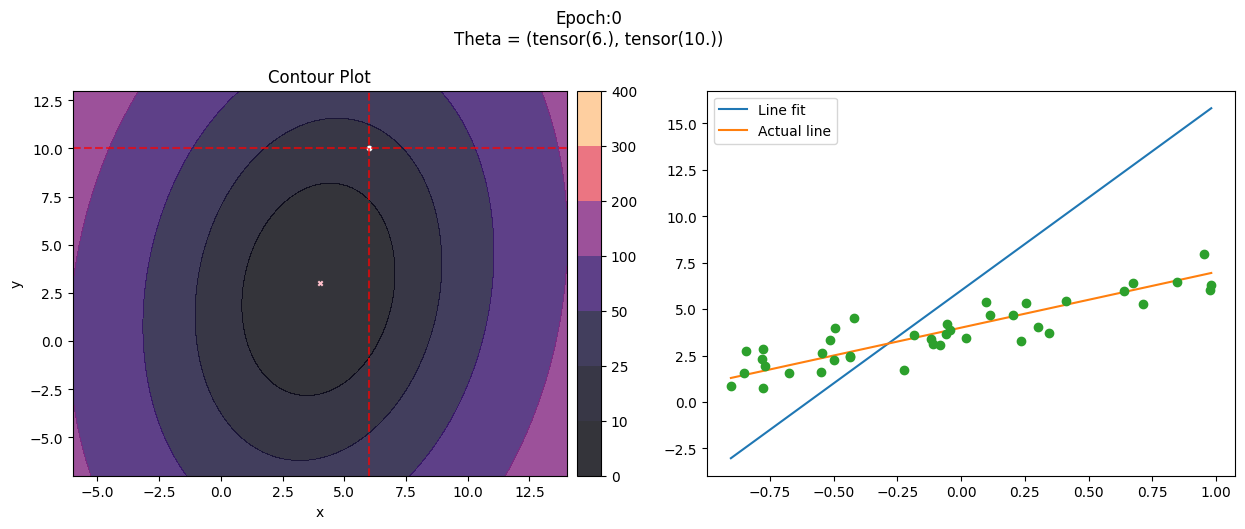

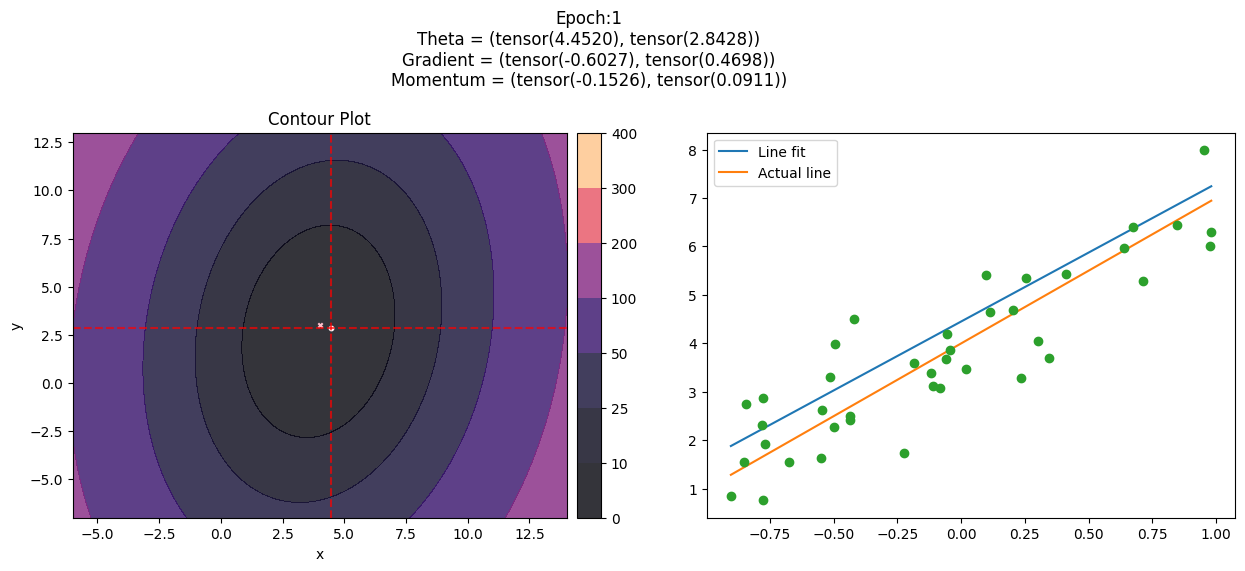

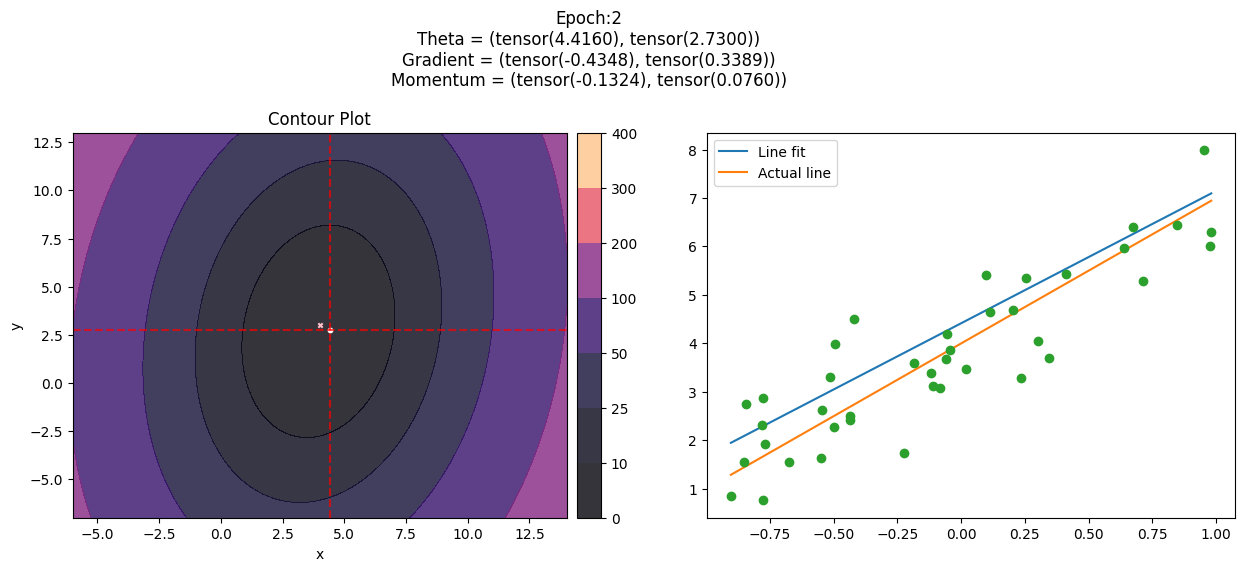

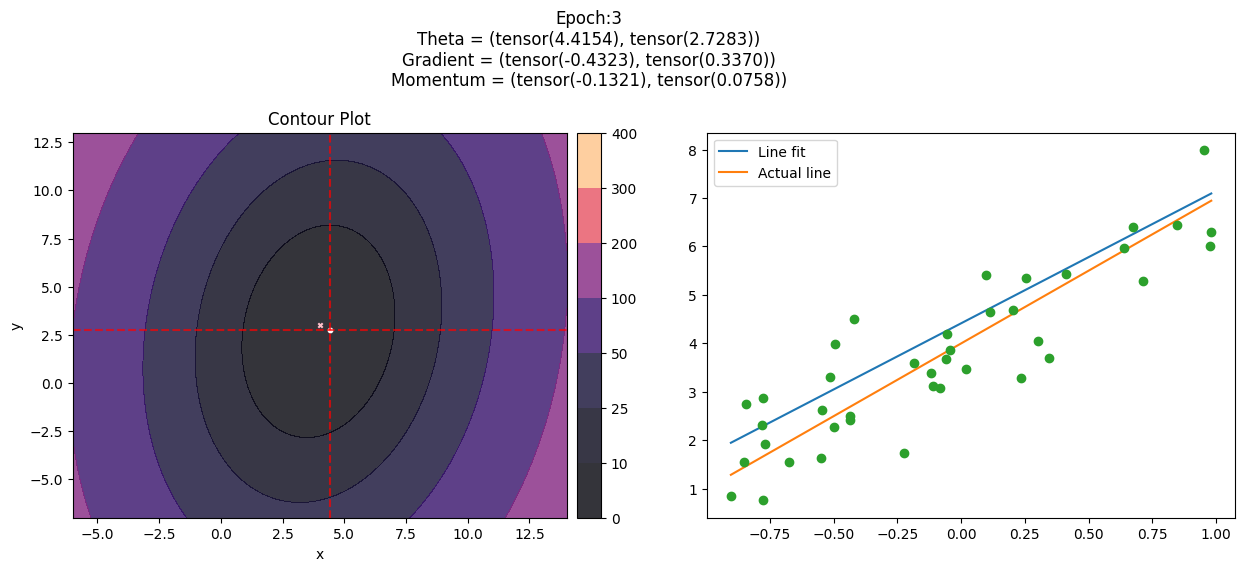

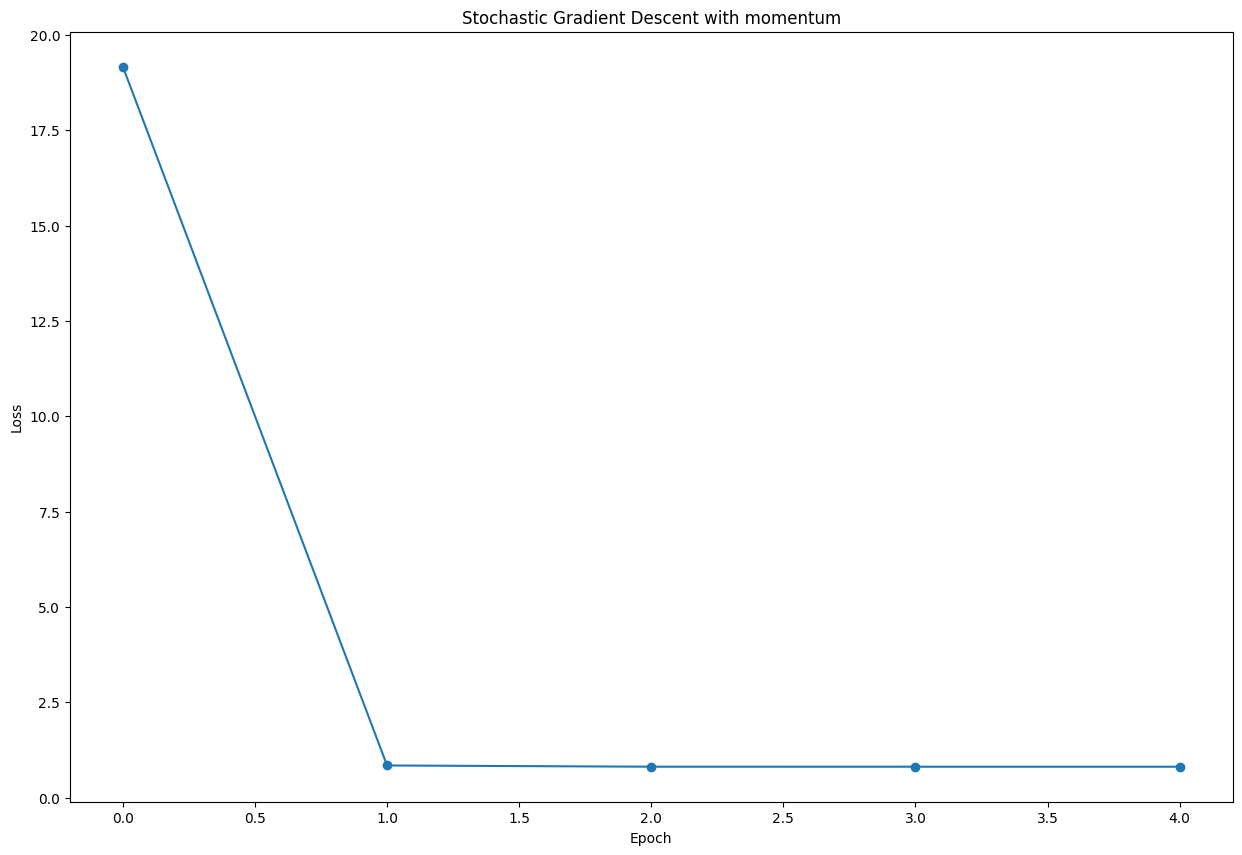

In [20]:
epochs_SGD, loss_SGD2=SGD_momentum(X1_tensor, y_tensor, theta0, theta1, 4, 3, a, momentum, epoch, loss_func)

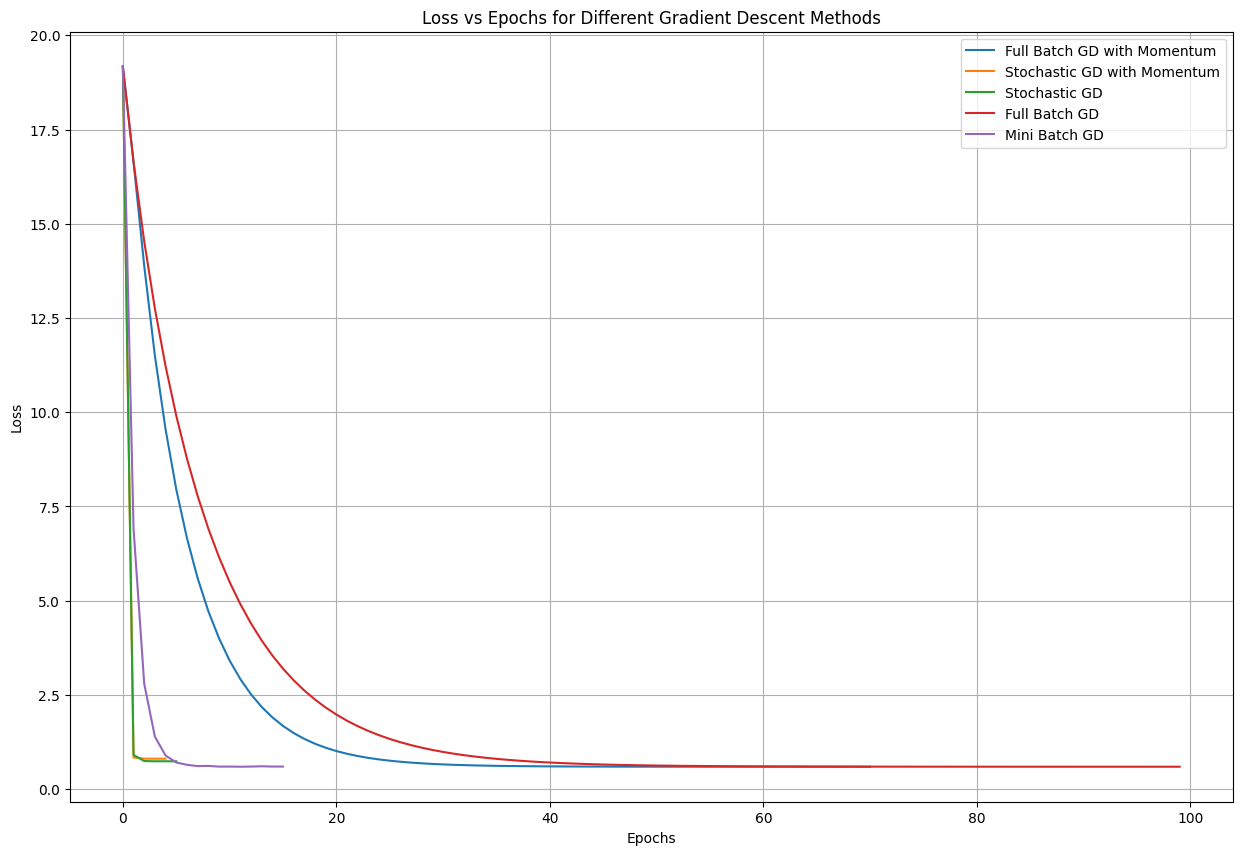

In [23]:

# epochs_vanilla, loss_vanilla = vanilla_gradient_descent(X, y, theta0, theta1, a, epoch, loss_func)  # Assuming this function returns epochs and loss too

# Plot all the methods in one plot
plt.figure(figsize=(15, 10))
plt.plot(epochs_FBD, loss_FBD2, label="Full Batch GD with Momentum")
plt.plot(epochs_SGD, loss_SGD2, label="Stochastic GD with Momentum")
plt.plot(epoch_SGD, loss_SGD, label="Stochastic GD ")
plt.plot(epoch_FBG, loss_FBG, label="Full Batch GD")
plt.plot(epoch_MBGD, loss_MBGD, label="Mini Batch GD")
plt.title("Loss vs Epochs for Different Gradient Descent Methods")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()